# 01. Comprehensive Exploratory Data Analysis (EDA)
**Satellite Imagery-Based Property Valuation - CDC X Yhills**

This notebook performs industry-grade EDA to understand:
1. Data quality and completeness
2. Target variable distribution and characteristics
3. Feature distributions and relationships
4. Geospatial patterns
5. Temporal patterns
6. Feature correlations and multicollinearity
7. Outliers and anomalies
8. Image availability analysis

## Setup and Data Loading

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

# Statistical tests
from scipy import stats
from scipy.stats import normaltest, shapiro, kstest

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# Load configuration
from config import *

# Load raw data
print("📂 Loading data...")
train_df = pd.read_excel(TRAIN_FILE)
test_df = pd.read_excel(TEST_FILE)

print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nTrain columns: {train_df.columns.tolist()}")

📂 Loading data...

Train shape: (16209, 21)
Test shape: (5404, 20)

Train columns: ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


## 1. Data Quality Assessment

In [3]:
def assess_data_quality(df, name="Dataset"):
    """Comprehensive data quality report"""
    print(f"\n{'='*80}")
    print(f"DATA QUALITY ASSESSMENT - {name}")
    print(f"{'='*80}\n")
    
    # Basic info
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Missing values
    print(f"\n{'─'*80}")
    print("MISSING VALUES")
    print(f"{'─'*80}")
    missing = df.isnull().sum()
    missing_pct = 100 * missing / len(df)
    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Missing_Percentage': missing_pct
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    
    if len(missing_df) > 0:
        print(missing_df)
    else:
        print("✅ No missing values found!")
    
    # Duplicates
    print(f"\n{'─'*80}")
    print("DUPLICATES")
    print(f"{'─'*80}")
    duplicates = df.duplicated().sum()
    print(f"Duplicate rows: {duplicates:,} ({100*duplicates/len(df):.2f}%)")
    
    if 'id' in df.columns:
        id_duplicates = df['id'].duplicated().sum()
        print(f"Duplicate IDs: {id_duplicates:,}")
    
    # Data types
    print(f"\n{'─'*80}")
    print("DATA TYPES")
    print(f"{'─'*80}")
    print(df.dtypes.value_counts())
    
    return missing_df

missing_train = assess_data_quality(train_df, "Training Set")
missing_test = assess_data_quality(test_df, "Test Set")


DATA QUALITY ASSESSMENT - Training Set

Shape: 16,209 rows × 21 columns
Memory usage: 3.46 MB

────────────────────────────────────────────────────────────────────────────────
MISSING VALUES
────────────────────────────────────────────────────────────────────────────────
✅ No missing values found!

────────────────────────────────────────────────────────────────────────────────
DUPLICATES
────────────────────────────────────────────────────────────────────────────────
Duplicate rows: 0 (0.00%)
Duplicate IDs: 99

────────────────────────────────────────────────────────────────────────────────
DATA TYPES
────────────────────────────────────────────────────────────────────────────────
int64      16
float64     4
object      1
Name: count, dtype: int64

DATA QUALITY ASSESSMENT - Test Set

Shape: 5,404 rows × 20 columns
Memory usage: 1.11 MB

────────────────────────────────────────────────────────────────────────────────
MISSING VALUES
─────────────────────────────────────────────────────

In [4]:
# Detailed summary statistics
print("\n📊 TRAINING SET - DETAILED STATISTICS\n")
display(train_df.describe(include='all').T)


📊 TRAINING SET - DETAILED STATISTICS



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,16209.000,NaN,NaN,NaN,4575770827.163,2874661405.393,1000102.000,2123049194.000,3904950190.000,7304301005.000,9900000190.000
date,16209,366,20140623T000000,115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,16209.000,NaN,NaN,NaN,537470.283,360303.577,75000.000,320000.000,450000.000,640000.000,7700000.000
bedrooms,16209.000,NaN,NaN,NaN,3.368,0.933,0.000,3.000,3.000,4.000,33.000
bathrooms,16209.000,NaN,NaN,NaN,2.113,0.765,0.000,1.500,2.250,2.500,8.000
sqft_living,16209.000,NaN,NaN,NaN,2073.275,907.009,290.000,1430.000,1910.000,2550.000,12050.000
sqft_lot,16209.000,NaN,NaN,NaN,14867.673,38825.702,520.000,5004.000,7599.000,10631.000,1164794.000
floors,16209.000,NaN,NaN,NaN,1.499,0.543,1.000,1.000,1.500,2.000,3.500
waterfront,16209.000,NaN,NaN,NaN,0.007,0.083,0.000,0.000,0.000,0.000,1.000
view,16209.000,NaN,NaN,NaN,0.234,0.763,0.000,0.000,0.000,0.000,4.000


## 2. Target Variable Analysis (Price)

In [5]:
print("\n" + "="*80)
print("TARGET VARIABLE ANALYSIS - PRICE")
print("="*80 + "\n")

# Summary statistics
price_stats = train_df['price'].describe()
print("Summary Statistics:")
print(f"  Count:    {price_stats['count']:>12,.0f}")
print(f"  Mean:     ${price_stats['mean']:>12,.2f}")
print(f"  Median:   ${price_stats['50%']:>12,.2f}")
print(f"  Std Dev:  ${price_stats['std']:>12,.2f}")
print(f"  Min:      ${price_stats['min']:>12,.2f}")
print(f"  Max:      ${price_stats['max']:>12,.2f}")
print(f"  Range:    ${price_stats['max'] - price_stats['min']:>12,.2f}")

# Distribution characteristics
print("\nDistribution Characteristics:")
skewness = train_df['price'].skew()
kurtosis = train_df['price'].kurtosis()
print(f"  Skewness: {skewness:>12.3f} {'(Right-skewed)' if skewness > 0 else '(Left-skewed)'}")
print(f"  Kurtosis: {kurtosis:>12.3f} {'(Heavy-tailed)' if kurtosis > 0 else '(Light-tailed)'}")

# Normality tests
print("\nNormality Tests:")
shapiro_stat, shapiro_p = shapiro(train_df['price'].sample(min(5000, len(train_df))))
print(f"  Shapiro-Wilk: statistic={shapiro_stat:.6f}, p-value={shapiro_p:.6f}")
print(f"  {'Not normal' if shapiro_p < 0.05 else 'Approximately normal'} distribution (α=0.05)")

# Percentiles
print("\nPercentiles:")
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    val = np.percentile(train_df['price'], p)
    print(f"  {p:>2}th: ${val:>12,.2f}")


TARGET VARIABLE ANALYSIS - PRICE

Summary Statistics:
  Count:          16,209
  Mean:     $  537,470.28
  Median:   $  450,000.00
  Std Dev:  $  360,303.58
  Min:      $   75,000.00
  Max:      $7,700,000.00
  Range:    $7,625,000.00

Distribution Characteristics:
  Skewness:        4.033 (Right-skewed)
  Kurtosis:       37.106 (Heavy-tailed)

Normality Tests:
  Shapiro-Wilk: statistic=0.699312, p-value=0.000000
  Not normal distribution (α=0.05)

Percentiles:
   1th: $  154,536.00
   5th: $  210,000.00
  10th: $  245,000.00
  25th: $  320,000.00
  50th: $  450,000.00
  75th: $  640,000.00
  90th: $  882,650.80
  95th: $1,150,000.00
  99th: $1,944,600.00


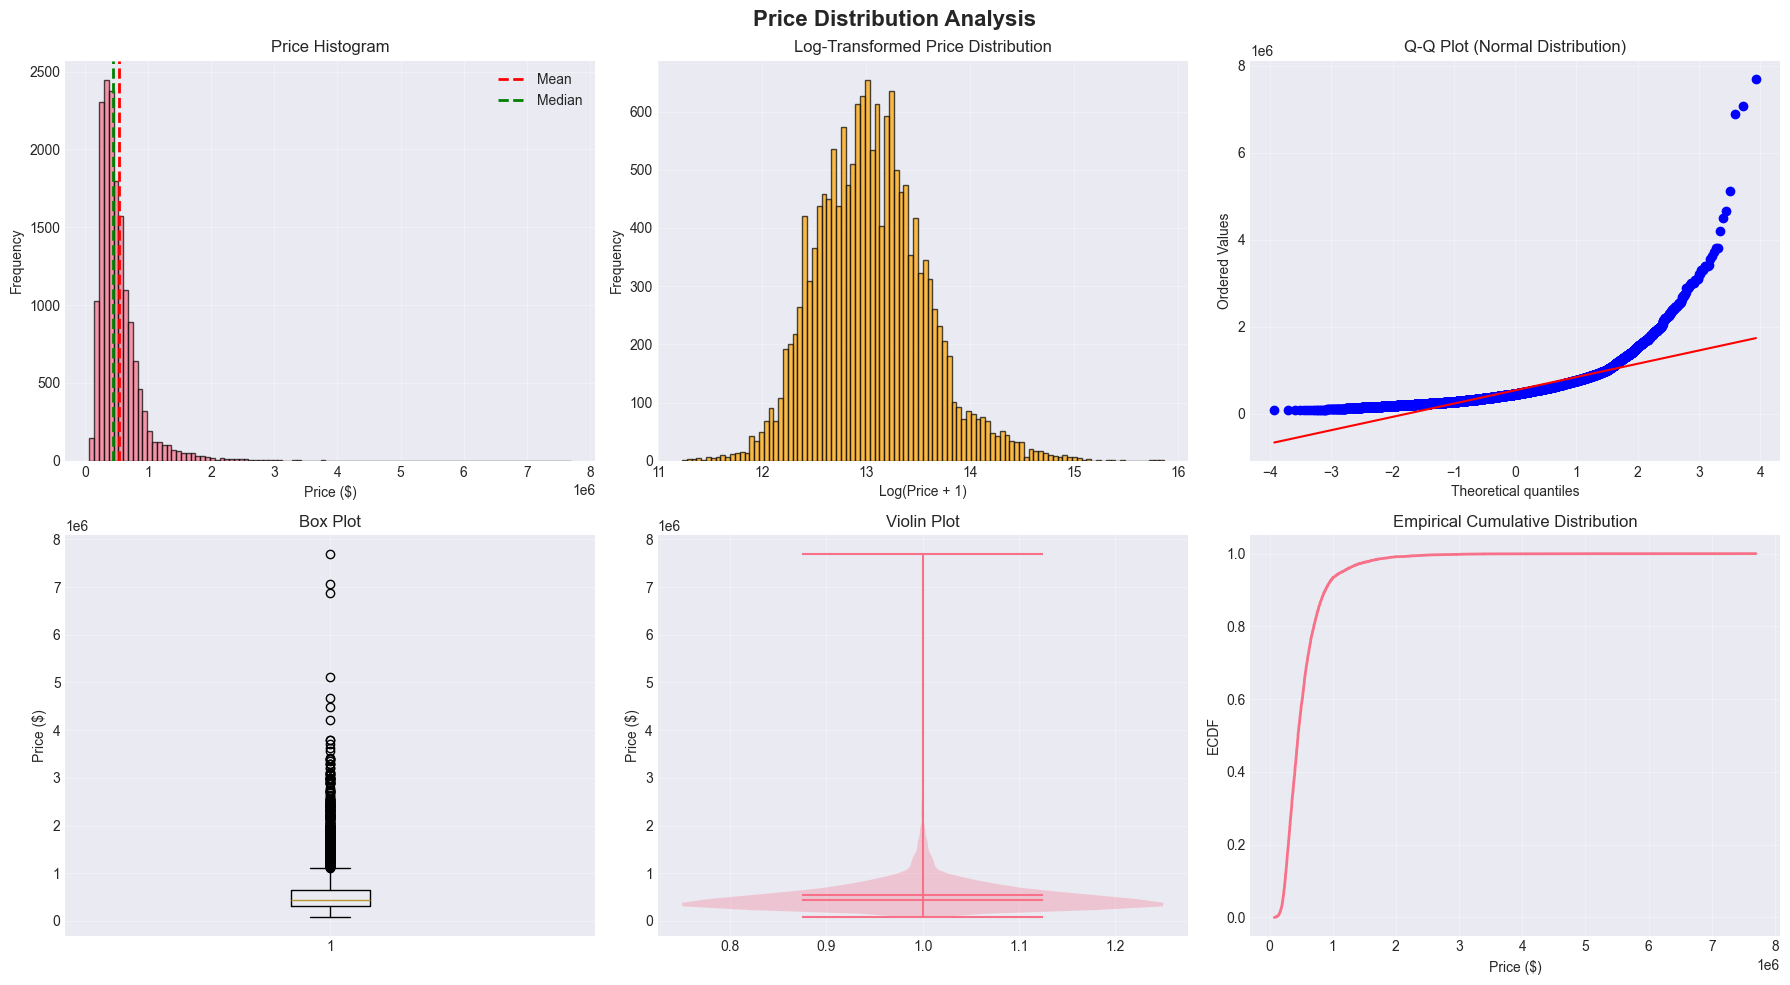

In [6]:
# Visualize price distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Price Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Histogram
axes[0, 0].hist(train_df['price'], bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(train_df['price'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].axvline(train_df['price'].median(), color='green', linestyle='--', linewidth=2, label='Median')
axes[0, 0].set_xlabel('Price ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Price Histogram')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Log-transformed histogram
axes[0, 1].hist(np.log1p(train_df['price']), bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Log(Price + 1)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Log-Transformed Price Distribution')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q plot
stats.probplot(train_df['price'], dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot (Normal Distribution)')
axes[0, 2].grid(True, alpha=0.3)

# 4. Box plot
axes[1, 0].boxplot(train_df['price'], vert=True)
axes[1, 0].set_ylabel('Price ($)')
axes[1, 0].set_title('Box Plot')
axes[1, 0].grid(True, alpha=0.3)

# 5. Violin plot
parts = axes[1, 1].violinplot([train_df['price']], vert=True, showmeans=True, showmedians=True)
axes[1, 1].set_ylabel('Price ($)')
axes[1, 1].set_title('Violin Plot')
axes[1, 1].grid(True, alpha=0.3)

# 6. ECDF (Empirical Cumulative Distribution Function)
sorted_prices = np.sort(train_df['price'])
y = np.arange(1, len(sorted_prices) + 1) / len(sorted_prices)
axes[1, 2].plot(sorted_prices, y, linewidth=2)
axes[1, 2].set_xlabel('Price ($)')
axes[1, 2].set_ylabel('ECDF')
axes[1, 2].set_title('Empirical Cumulative Distribution')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Numerical Features Analysis

In [7]:
# Identify numerical columns
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['id', 'price']]

print(f"\n📊 Found {len(numerical_cols)} numerical features:\n")
for i, col in enumerate(numerical_cols, 1):
    print(f"  {i:2d}. {col}")


📊 Found 18 numerical features:

   1. bedrooms
   2. bathrooms
   3. sqft_living
   4. sqft_lot
   5. floors
   6. waterfront
   7. view
   8. condition
   9. grade
  10. sqft_above
  11. sqft_basement
  12. yr_built
  13. yr_renovated
  14. zipcode
  15. lat
  16. long
  17. sqft_living15
  18. sqft_lot15


In [31]:
# Detailed statistics for each numerical feature
def analyze_numerical_feature(df, col):
    """Detailed analysis of a numerical feature"""
    print(f"\n{'─'*80}")
    print(f"Feature: {col.upper()}")
    print(f"{'─'*80}")
    
    data = df[col].dropna()
    
    # Basic stats
    print(f"Count:       {len(data):>12,}")
    print(f"Mean:        {data.mean():>12.2f}")
    print(f"Median:      {data.median():>12.2f}")
    print(f"Std Dev:     {data.std():>12.2f}")
    print(f"Min:         {data.min():>12.2f}")
    print(f"Max:         {data.max():>12.2f}")
    print(f"Range:       {data.max() - data.min():>12.2f}")
    
    # Distribution
    print(f"\nSkewness:    {data.skew():>12.3f}")
    print(f"Kurtosis:    {data.kurtosis():>12.3f}")
    
    # Unique values
    n_unique = data.nunique()
    print(f"\nUnique:      {n_unique:>12,}")
    if n_unique <= 20:
        print(f"Values:      {sorted(data.unique())}")
    
    # Zeros
    n_zeros = (data == 0).sum()
    print(f"Zeros:       {n_zeros:>12,} ({100*n_zeros/len(data):.2f}%)")
    
    # Correlation with price
    if 'price' in df.columns:
        corr = df[[col, 'price']].corr().iloc[0, 1]
        print(f"\nCorr w/ Price: {corr:>10.4f}")

# Analyze each numerical feature
for col in numerical_cols[:13]:  # First 5 for brevity
    analyze_numerical_feature(train_df, col)


────────────────────────────────────────────────────────────────────────────────
Feature: BEDROOMS
────────────────────────────────────────────────────────────────────────────────
Count:             16,209
Mean:                3.37
Median:              3.00
Std Dev:             0.93
Min:                 0.00
Max:                33.00
Range:              33.00

Skewness:           2.419
Kurtosis:          63.748

Unique:                12
Values:      [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(33)]
Zeros:                  8 (0.05%)

Corr w/ Price:     0.3045

────────────────────────────────────────────────────────────────────────────────
Feature: BATHROOMS
────────────────────────────────────────────────────────────────────────────────
Count:             16,209
Mean:                2.11
Median:              2.25
Std Dev:             0.77
Min:                 0.00
Max:        

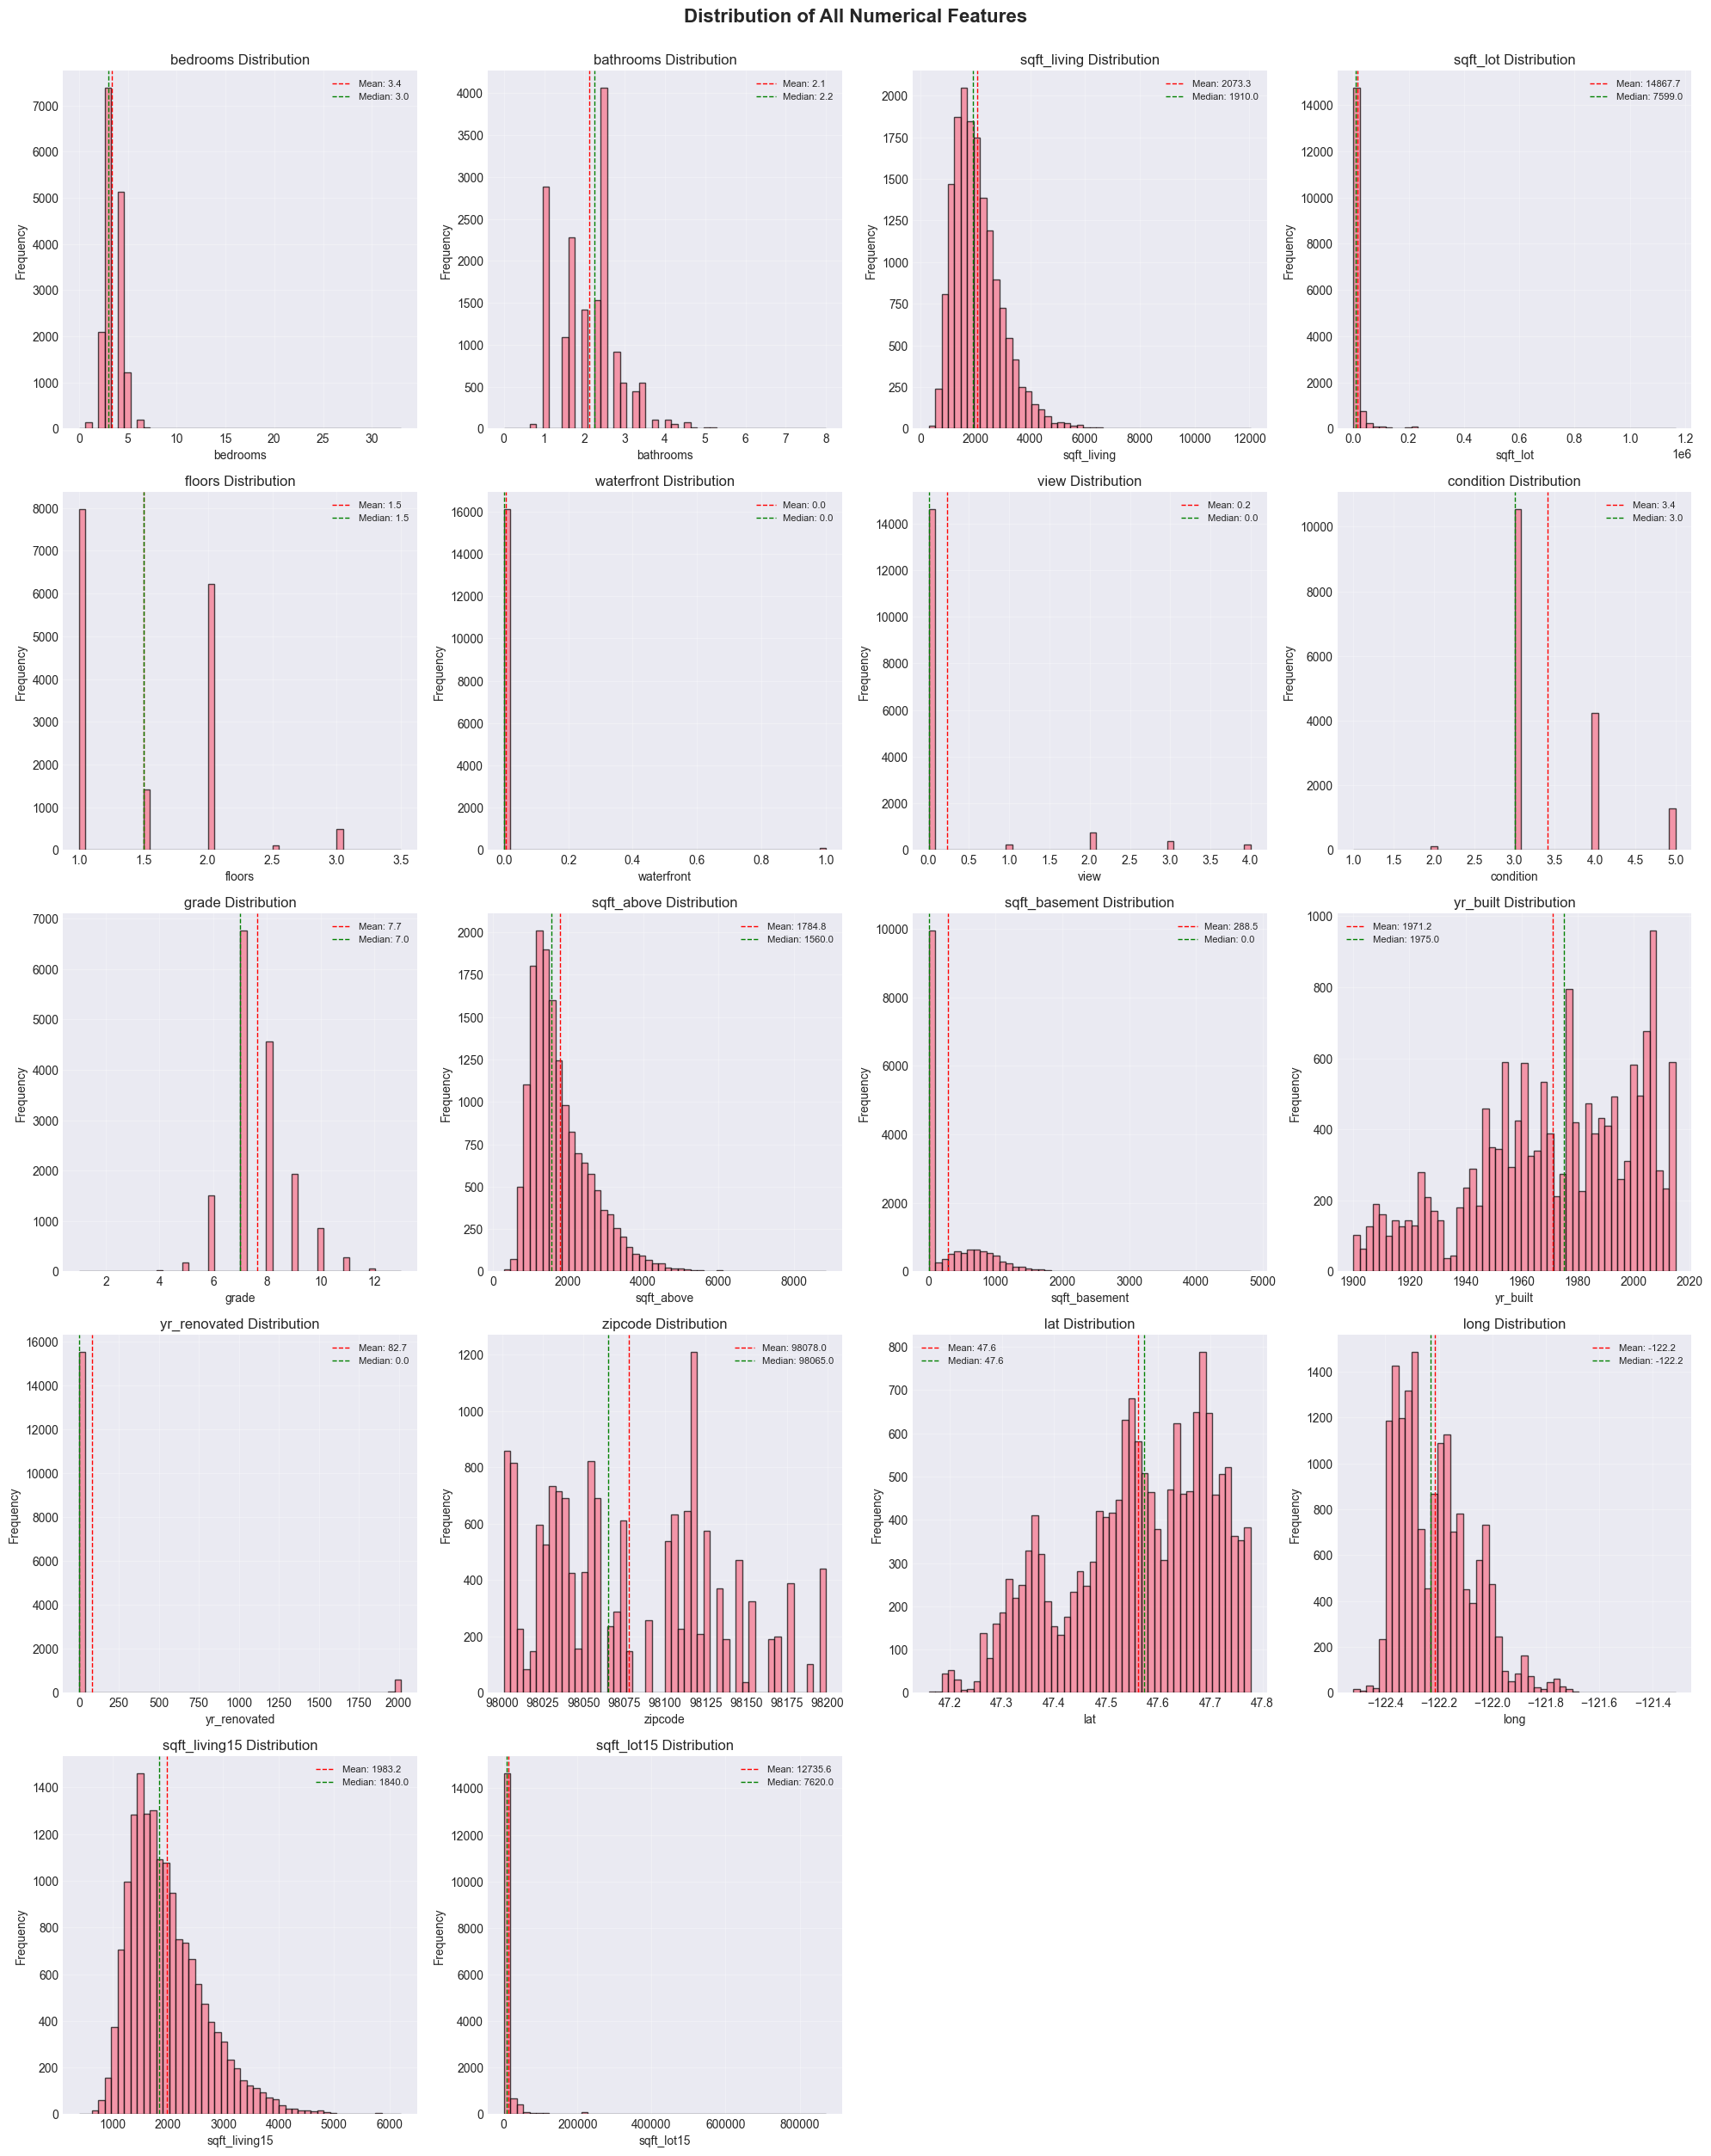

In [9]:
# Distribution plots for all numerical features
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(train_df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = train_df[col].mean()
    median_val = train_df[col].median()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean_val:.1f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=1, label=f'Median: {median_val:.1f}')
    axes[idx].legend(fontsize=8)

# Hide empty subplots
for idx in range(len(numerical_cols), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Distribution of All Numerical Features', fontsize=16, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

## 4. Correlation Analysis


📊 CORRELATION WITH PRICE

price            1.000
sqft_living      0.701
grade            0.664
sqft_above       0.603
sqft_living15    0.582
bathrooms        0.525
view             0.391
sqft_basement    0.320
lat              0.310
bedrooms         0.304
floors           0.251
waterfront       0.245
yr_renovated     0.133
sqft_lot         0.089
sqft_lot15       0.076
yr_built         0.048
condition        0.031
long             0.024
zipcode         -0.055


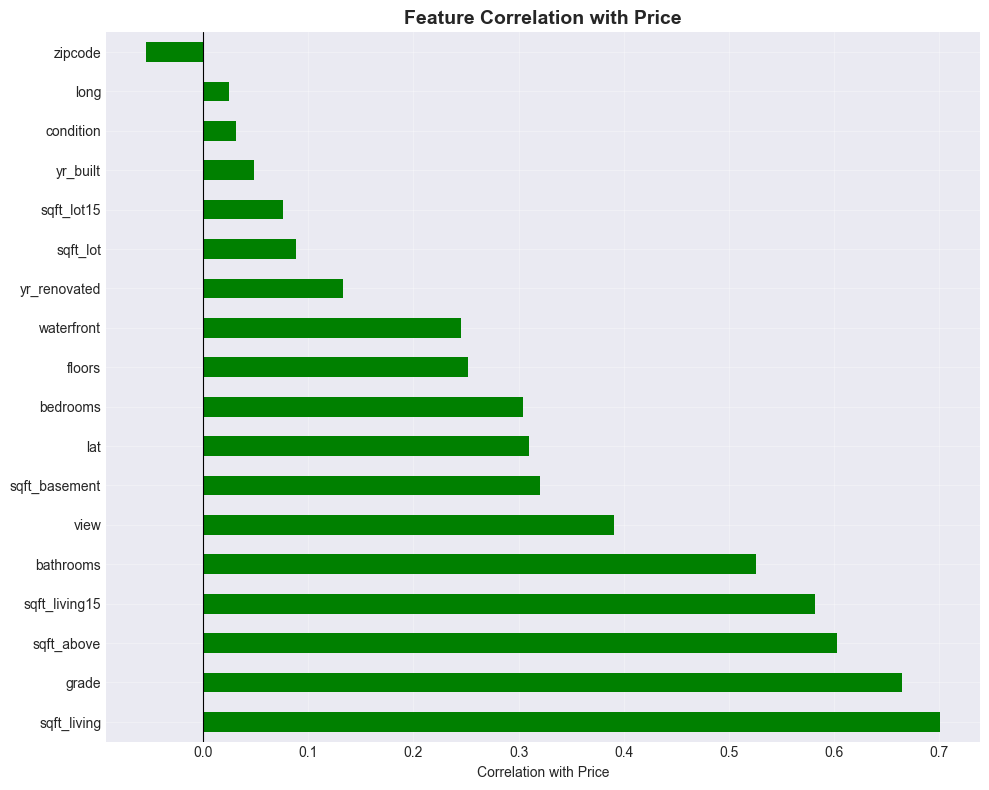

In [10]:
# Correlation matrix
print("\n📊 CORRELATION WITH PRICE\n")
price_corr = train_df[numerical_cols + ['price']].corr()['price'].sort_values(ascending=False)
print(price_corr.to_string())

# Visualize correlations with price
fig, ax = plt.subplots(figsize=(10, 8))
price_corr_df = price_corr.drop('price').to_frame()
colors = ['green' if x > 0 else 'red' for x in price_corr_df['price']]
price_corr_df.plot(kind='barh', ax=ax, color=colors, legend=False)
ax.set_xlabel('Correlation with Price')
ax.set_title('Feature Correlation with Price', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

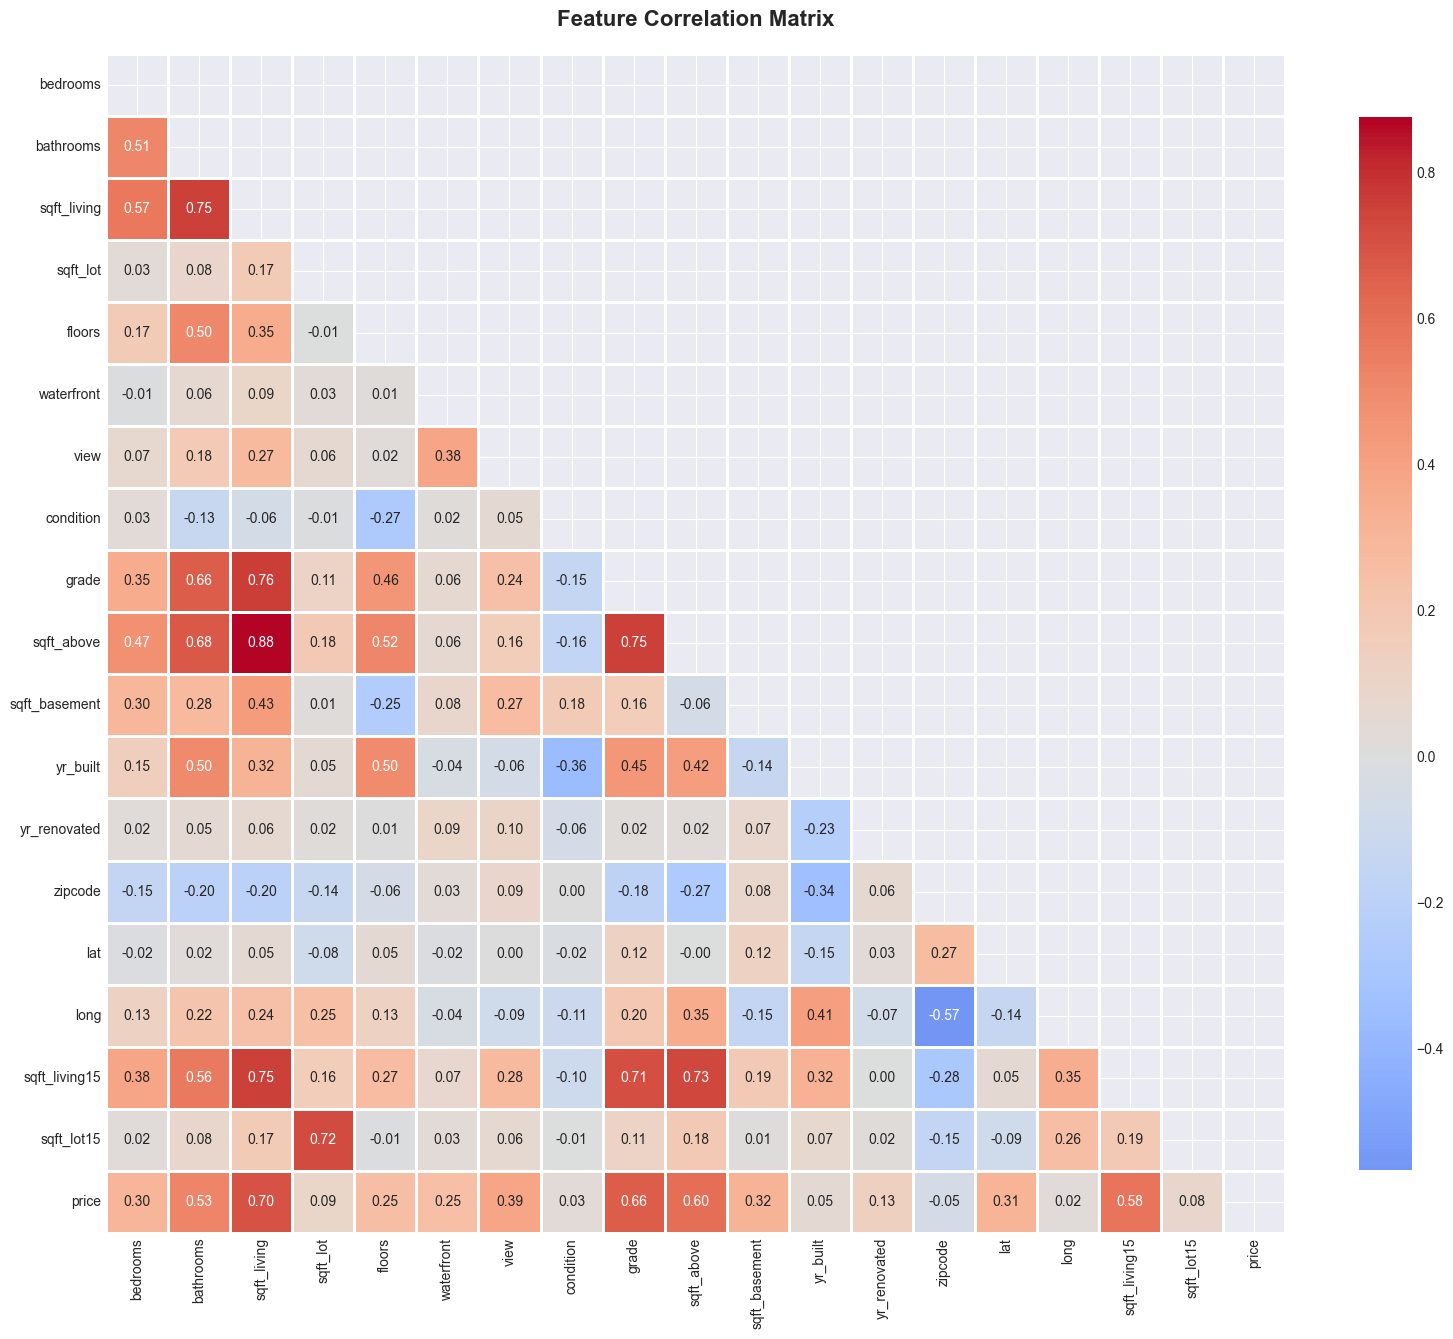

In [11]:
# Full correlation heatmap
plt.figure(figsize=(16, 14))
corr_matrix = train_df[numerical_cols + ['price']].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [12]:
# Identify highly correlated features (multicollinearity)
print("\n⚠️  HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8)\n")

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    for feat1, feat2, corr_val in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {feat1:20s} <-> {feat2:20s} : {corr_val:>6.3f}")
else:
    print("  ✅ No highly correlated pairs found")


⚠️  HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8)

  sqft_living          <-> sqft_above           :  0.876


## 5. Categorical Features Analysis

In [13]:
# Identify categorical/discrete features
categorical_features = []

for col in numerical_cols:
    if train_df[col].nunique() <= 20:  # Treat as categorical if <= 20 unique values
        categorical_features.append(col)

print(f"\n📊 CATEGORICAL/DISCRETE FEATURES ({len(categorical_features)}):")
print(categorical_features)

# Analyze each categorical feature
for col in categorical_features:
    print(f"\n{'─'*80}")
    print(f"{col.upper()}")
    print(f"{'─'*80}")
    
    value_counts = train_df[col].value_counts().sort_index()
    value_pct = 100 * value_counts / len(train_df)
    
    result_df = pd.DataFrame({
        'Count': value_counts,
        'Percentage': value_pct,
        'Avg_Price': train_df.groupby(col)['price'].mean()
    })
    
    print(result_df.to_string())


📊 CATEGORICAL/DISCRETE FEATURES (6):
['bedrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

────────────────────────────────────────────────────────────────────────────────
BEDROOMS
────────────────────────────────────────────────────────────────────────────────
          Count  Percentage  Avg_Price
bedrooms                              
0             8       0.049 379200.000
1           142       0.876 315634.725
2          2098      12.943 402120.493
3          7380      45.530 465212.399
4          5128      31.637 631956.178
5          1213       7.483 783777.411
6           197       1.215 805518.726
7            26       0.160 831550.654
8             9       0.056 892555.556
9             5       0.031 982799.800
10            2       0.012 899000.000
33            1       0.006 640000.000

────────────────────────────────────────────────────────────────────────────────
FLOORS
────────────────────────────────────────────────────────────────────────────────
       

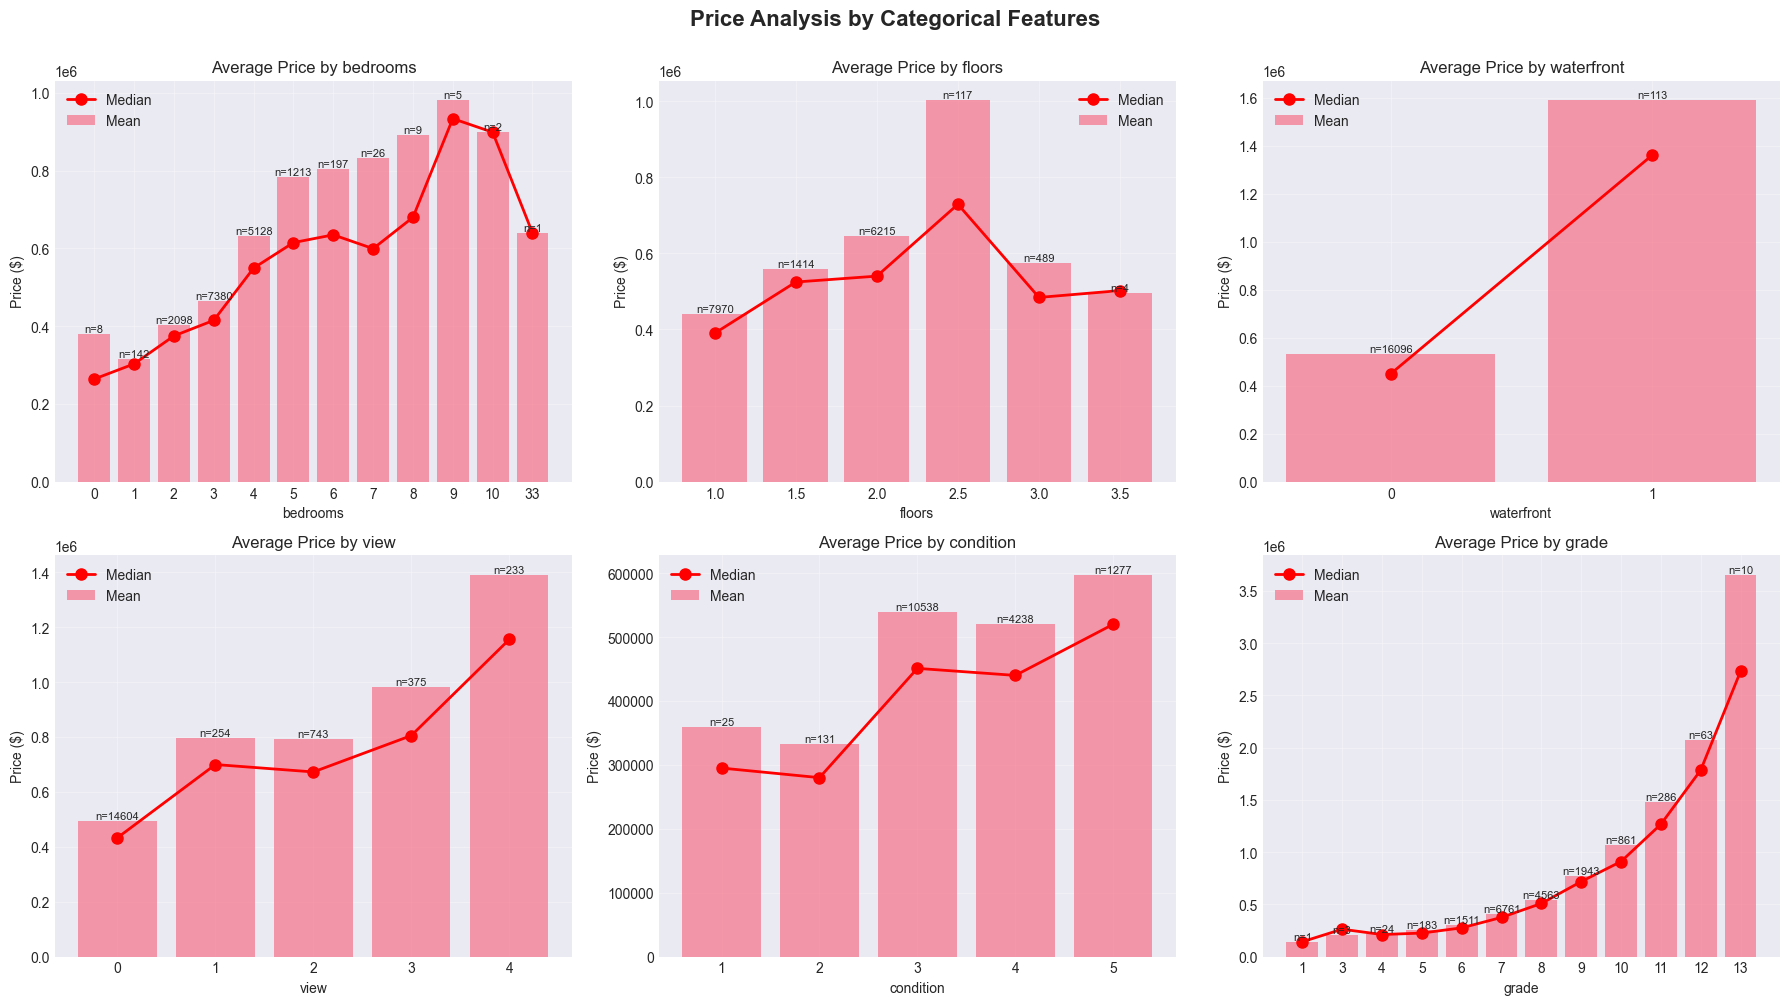

In [14]:
# Visualize categorical features vs price
n_cat = len(categorical_features)
if n_cat > 0:
    n_cols = 3
    n_rows = (n_cat + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, col in enumerate(categorical_features):
        avg_prices = train_df.groupby(col)['price'].agg(['mean', 'median', 'count'])
        
        x_pos = np.arange(len(avg_prices))
        axes[idx].bar(x_pos, avg_prices['mean'], alpha=0.7, label='Mean')
        axes[idx].plot(x_pos, avg_prices['median'], 'ro-', linewidth=2, markersize=8, label='Median')
        
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Price ($)')
        axes[idx].set_title(f'Average Price by {col}')
        axes[idx].set_xticks(x_pos)
        axes[idx].set_xticklabels(avg_prices.index)
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
        
        # Add counts as text
        for i, (mean_val, count) in enumerate(zip(avg_prices['mean'], avg_prices['count'])):
            axes[idx].text(i, mean_val, f'n={count}', ha='center', va='bottom', fontsize=8)
    
    # Hide empty subplots
    for idx in range(n_cat, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Price Analysis by Categorical Features', fontsize=16, fontweight='bold', y=1.001)
    plt.tight_layout()
    plt.show()

## 6. Geospatial Analysis

In [15]:
print("\n" + "="*80)
print("GEOSPATIAL ANALYSIS")
print("="*80 + "\n")

# Coordinate ranges
print("Coordinate Ranges:")
print(f"  Latitude:  {train_df['lat'].min():.6f} to {train_df['lat'].max():.6f}")
print(f"  Longitude: {train_df['long'].min():.6f} to {train_df['long'].max():.6f}")
print(f"  Lat range: {train_df['lat'].max() - train_df['lat'].min():.6f}°")
print(f"  Long range: {train_df['long'].max() - train_df['long'].min():.6f}°")


GEOSPATIAL ANALYSIS

Coordinate Ranges:
  Latitude:  47.159300 to 47.777600
  Longitude: -122.519000 to -121.315000
  Lat range: 0.618300°
  Long range: 1.204000°


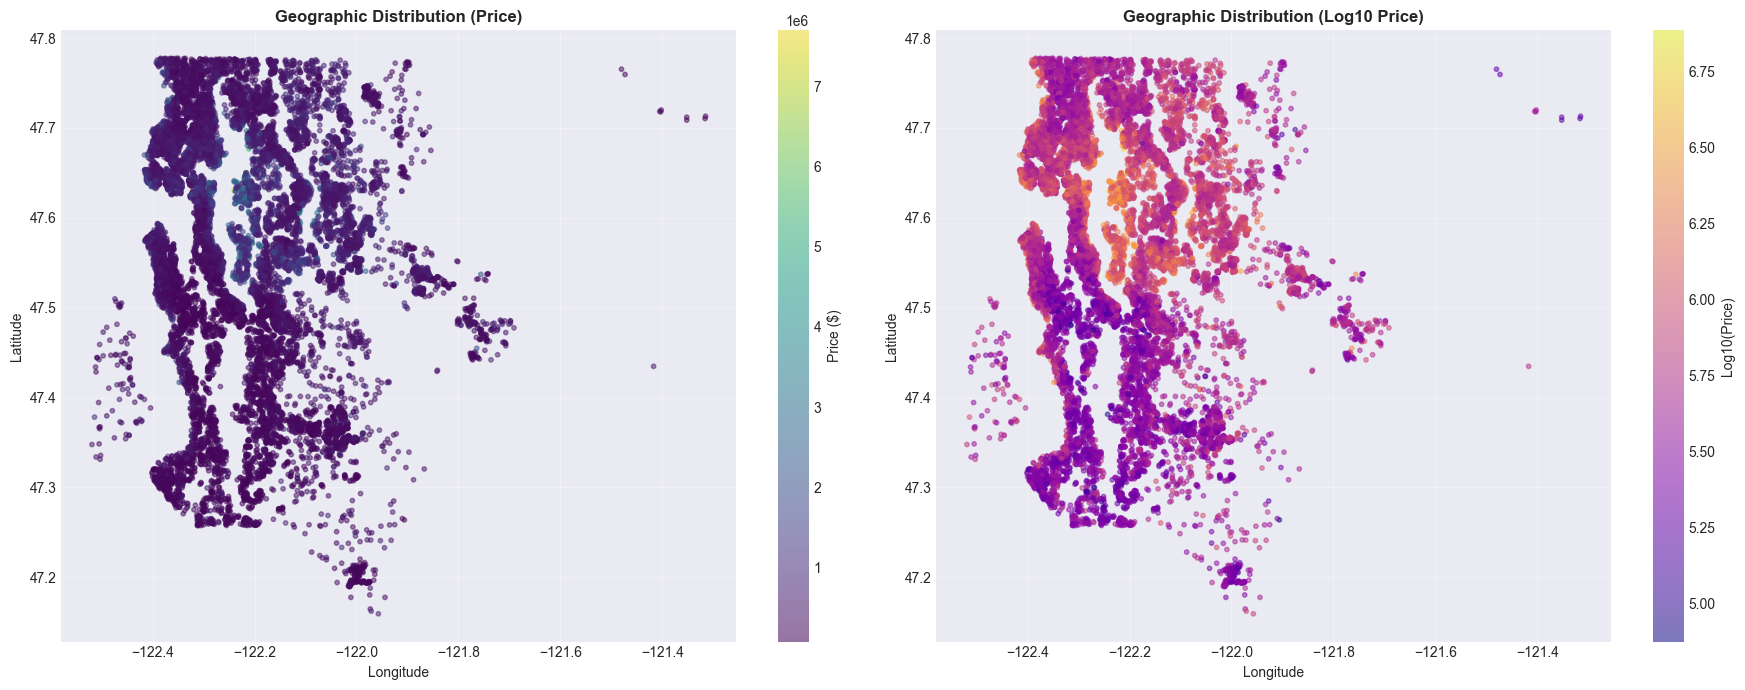

In [16]:
# Scatter plot: Geographic distribution colored by price
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Raw prices
scatter1 = axes[0].scatter(train_df['long'], train_df['lat'], 
                          c=train_df['price'], cmap='viridis', 
                          alpha=0.5, s=10)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Geographic Distribution (Price)', fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Price ($)')
axes[0].grid(True, alpha=0.3)

# Log prices (better visualization)
scatter2 = axes[1].scatter(train_df['long'], train_df['lat'], 
                          c=np.log10(train_df['price']), cmap='plasma', 
                          alpha=0.5, s=10)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Geographic Distribution (Log10 Price)', fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Log10(Price)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

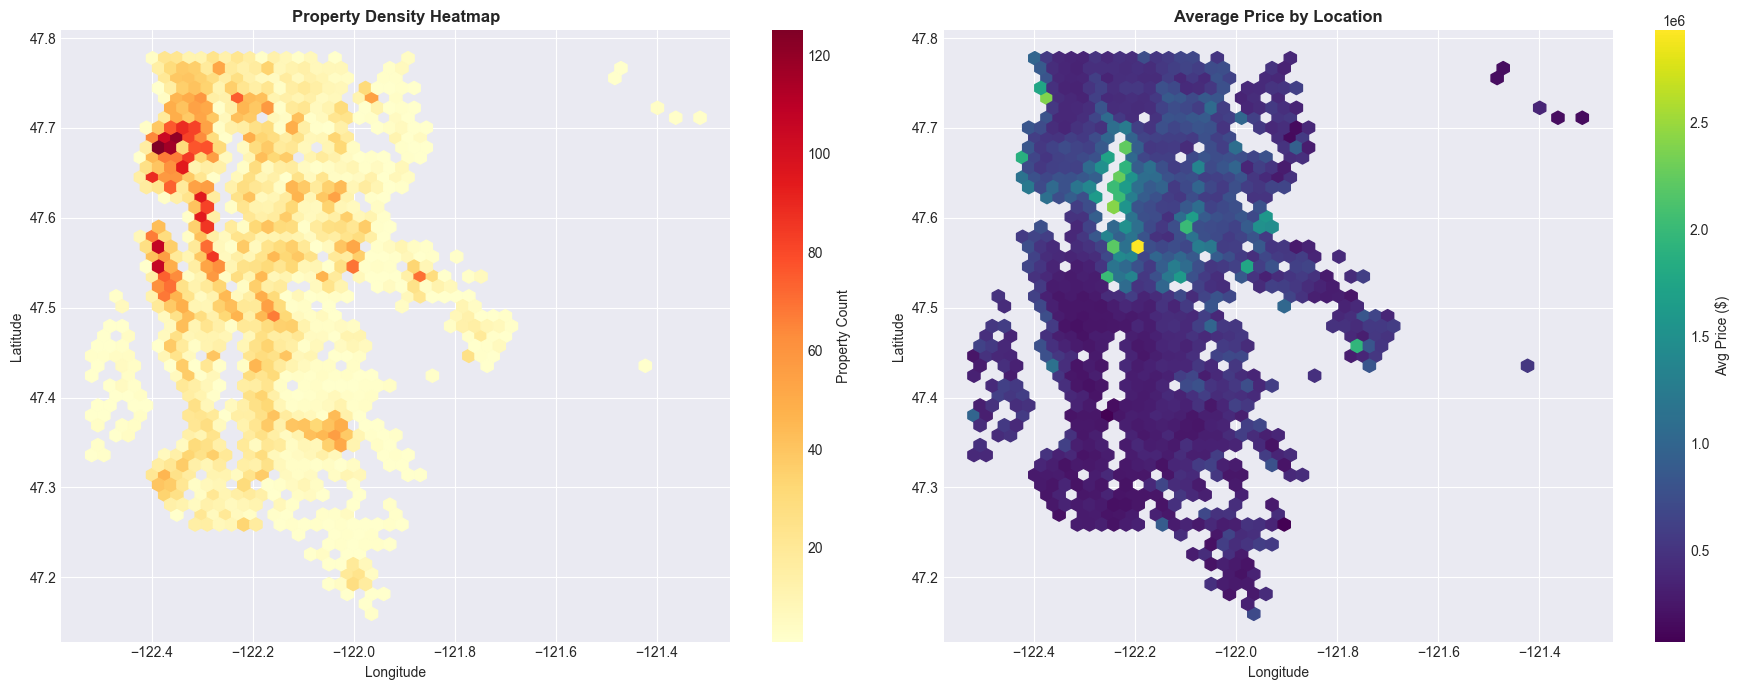

In [17]:
# 2D Hexbin density plot
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Property density
hexbin1 = axes[0].hexbin(train_df['long'], train_df['lat'], 
                         gridsize=50, cmap='YlOrRd', mincnt=1)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Property Density Heatmap', fontweight='bold')
plt.colorbar(hexbin1, ax=axes[0], label='Property Count')

# Average price density
hexbin2 = axes[1].hexbin(train_df['long'], train_df['lat'], 
                         C=train_df['price'], gridsize=50, 
                         cmap='viridis', reduce_C_function=np.mean, mincnt=1)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Average Price by Location', fontweight='bold')
plt.colorbar(hexbin2, ax=axes[1], label='Avg Price ($)')

plt.tight_layout()
plt.show()

In [18]:
# Interactive map with Plotly
print("\n📍 Creating interactive map...")

# Sample for performance (plot all if dataset is small)
sample_size = min(5000, len(train_df))
sample_df = train_df.sample(sample_size, random_state=42)

fig = px.scatter_mapbox(sample_df, 
                        lat='lat', 
                        lon='long', 
                        color='price',
                        size='sqft_living',
                        hover_data=['price', 'bedrooms', 'bathrooms', 'sqft_living', 'grade'],
                        color_continuous_scale='Viridis',
                        zoom=9,
                        height=700,
                        title=f'Interactive Property Map (Sample: {sample_size:,} properties)')

fig.update_layout(mapbox_style='open-street-map')
fig.show()


📍 Creating interactive map...


## 7. Temporal Analysis

In [19]:
if 'date' in train_df.columns:
    print("\n" + "="*80)
    print("TEMPORAL ANALYSIS")
    print("="*80 + "\n")
    
    # Parse dates
    train_df['date'] = pd.to_datetime(train_df['date'], format='%Y%m%dT%H%M%S', errors='coerce')
    
    # Extract components
    train_df['year'] = train_df['date'].dt.year
    train_df['month'] = train_df['date'].dt.month
    train_df['day_of_week'] = train_df['date'].dt.dayofweek
    train_df['quarter'] = train_df['date'].dt.quarter
    
    print(f"Date range: {train_df['date'].min()} to {train_df['date'].max()}")
    print(f"\nSales by Year:")
    print(train_df['year'].value_counts().sort_index())
    
    print(f"\nSales by Month:")
    print(train_df['month'].value_counts().sort_index())
    
    print(f"\nSales by Day of Week:")
    dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_counts = train_df['day_of_week'].value_counts().sort_index()
    for dow, count in dow_counts.items():
        print(f"  {dow_names[dow]:10s}: {count:>6,}")


TEMPORAL ANALYSIS

Date range: 2014-05-02 00:00:00 to 2015-05-24 00:00:00

Sales by Year:
year
2014    10990
2015     5219
Name: count, dtype: int64

Sales by Month:
month
1      733
2      930
3     1414
4     1663
5     1789
6     1642
7     1655
8     1451
9     1376
10    1398
11    1063
12    1095
Name: count, dtype: int64

Sales by Day of Week:
  Monday    :  3,072
  Tuesday   :  3,543
  Wednesday :  3,469
  Thursday  :  2,999
  Friday    :  2,743
  Saturday  :    209
  Sunday    :    174


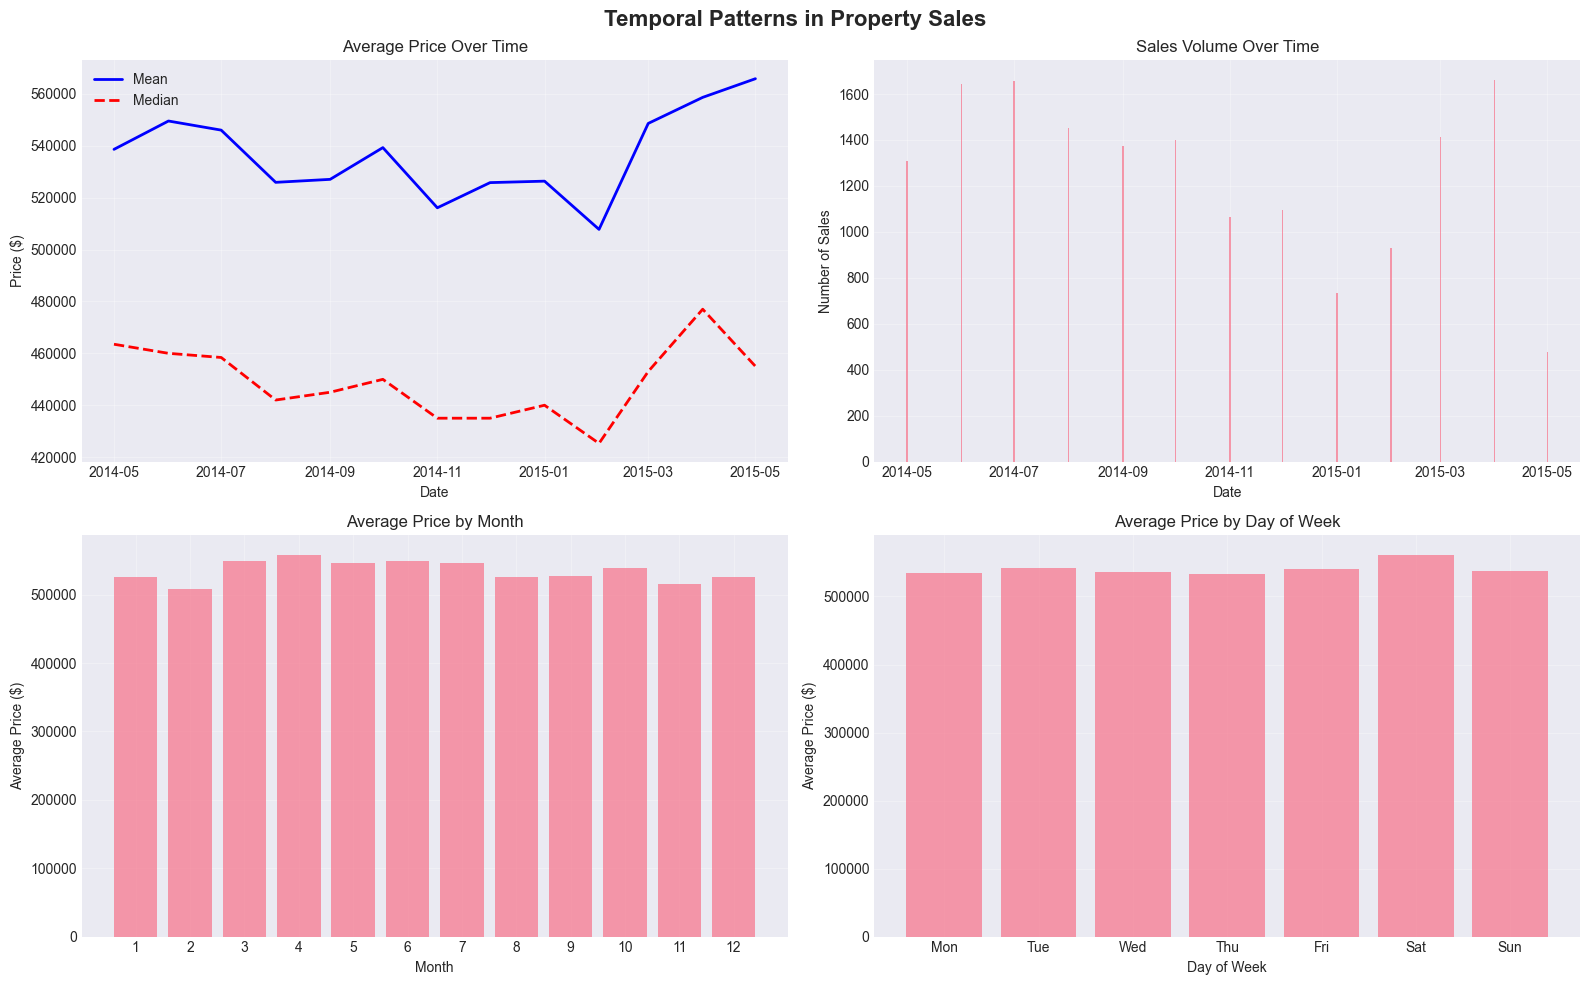

In [20]:
if 'date' in train_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Price over time
    monthly_avg = train_df.groupby(train_df['date'].dt.to_period('M'))['price'].agg(['mean', 'median', 'count'])
    monthly_avg.index = monthly_avg.index.to_timestamp()
    
    axes[0, 0].plot(monthly_avg.index, monthly_avg['mean'], 'b-', linewidth=2, label='Mean')
    axes[0, 0].plot(monthly_avg.index, monthly_avg['median'], 'r--', linewidth=2, label='Median')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Price ($)')
    axes[0, 0].set_title('Average Price Over Time')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Sales volume over time
    axes[0, 1].bar(monthly_avg.index, monthly_avg['count'], alpha=0.7)
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Number of Sales')
    axes[0, 1].set_title('Sales Volume Over Time')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Price by month
    monthly_price = train_df.groupby('month')['price'].mean()
    axes[1, 0].bar(monthly_price.index, monthly_price.values, alpha=0.7)
    axes[1, 0].set_xlabel('Month')
    axes[1, 0].set_ylabel('Average Price ($)')
    axes[1, 0].set_title('Average Price by Month')
    axes[1, 0].set_xticks(range(1, 13))
    axes[1, 0].grid(True, alpha=0.3)
    
    # Price by day of week
    dow_price = train_df.groupby('day_of_week')['price'].mean()
    axes[1, 1].bar(dow_price.index, dow_price.values, alpha=0.7)
    axes[1, 1].set_xlabel('Day of Week')
    axes[1, 1].set_ylabel('Average Price ($)')
    axes[1, 1].set_title('Average Price by Day of Week')
    axes[1, 1].set_xticks(range(7))
    axes[1, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Temporal Patterns in Property Sales', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 8. Property Age and Renovation Analysis

In [21]:
print("\n" + "="*80)
print("PROPERTY AGE & RENOVATION ANALYSIS")
print("="*80 + "\n")

# Property age
current_year = 2025
train_df['property_age'] = current_year - train_df['yr_built']

print(f"Year Built:")
print(f"  Min: {train_df['yr_built'].min():.0f}")
print(f"  Max: {train_df['yr_built'].max():.0f}")
print(f"  Mean: {train_df['yr_built'].mean():.1f}")

print(f"\nProperty Age:")
print(f"  Min: {train_df['property_age'].min():.0f} years")
print(f"  Max: {train_df['property_age'].max():.0f} years")
print(f"  Mean: {train_df['property_age'].mean():.1f} years")

# Renovation analysis
renovated = (train_df['yr_renovated'] > 0).sum()
print(f"\nRenovation:")
print(f"  Renovated properties: {renovated:,} ({100*renovated/len(train_df):.2f}%)")
print(f"  Not renovated: {len(train_df) - renovated:,} ({100*(1-renovated/len(train_df)):.2f}%)")

if renovated > 0:
    renovated_df = train_df[train_df['yr_renovated'] > 0]
    print(f"\n  Avg price (renovated): ${renovated_df['price'].mean():,.2f}")
    print(f"  Avg price (not renovated): ${train_df[train_df['yr_renovated'] == 0]['price'].mean():,.2f}")
    print(f"  Price premium: ${renovated_df['price'].mean() - train_df[train_df['yr_renovated'] == 0]['price'].mean():,.2f}")


PROPERTY AGE & RENOVATION ANALYSIS

Year Built:
  Min: 1900
  Max: 2015
  Mean: 1971.2

Property Age:
  Min: 10 years
  Max: 125 years
  Mean: 53.8 years

Renovation:
  Renovated properties: 672 (4.15%)
  Not renovated: 15,537 (95.85%)

  Avg price (renovated): $767,413.01
  Avg price (not renovated): $527,524.89
  Price premium: $239,888.11


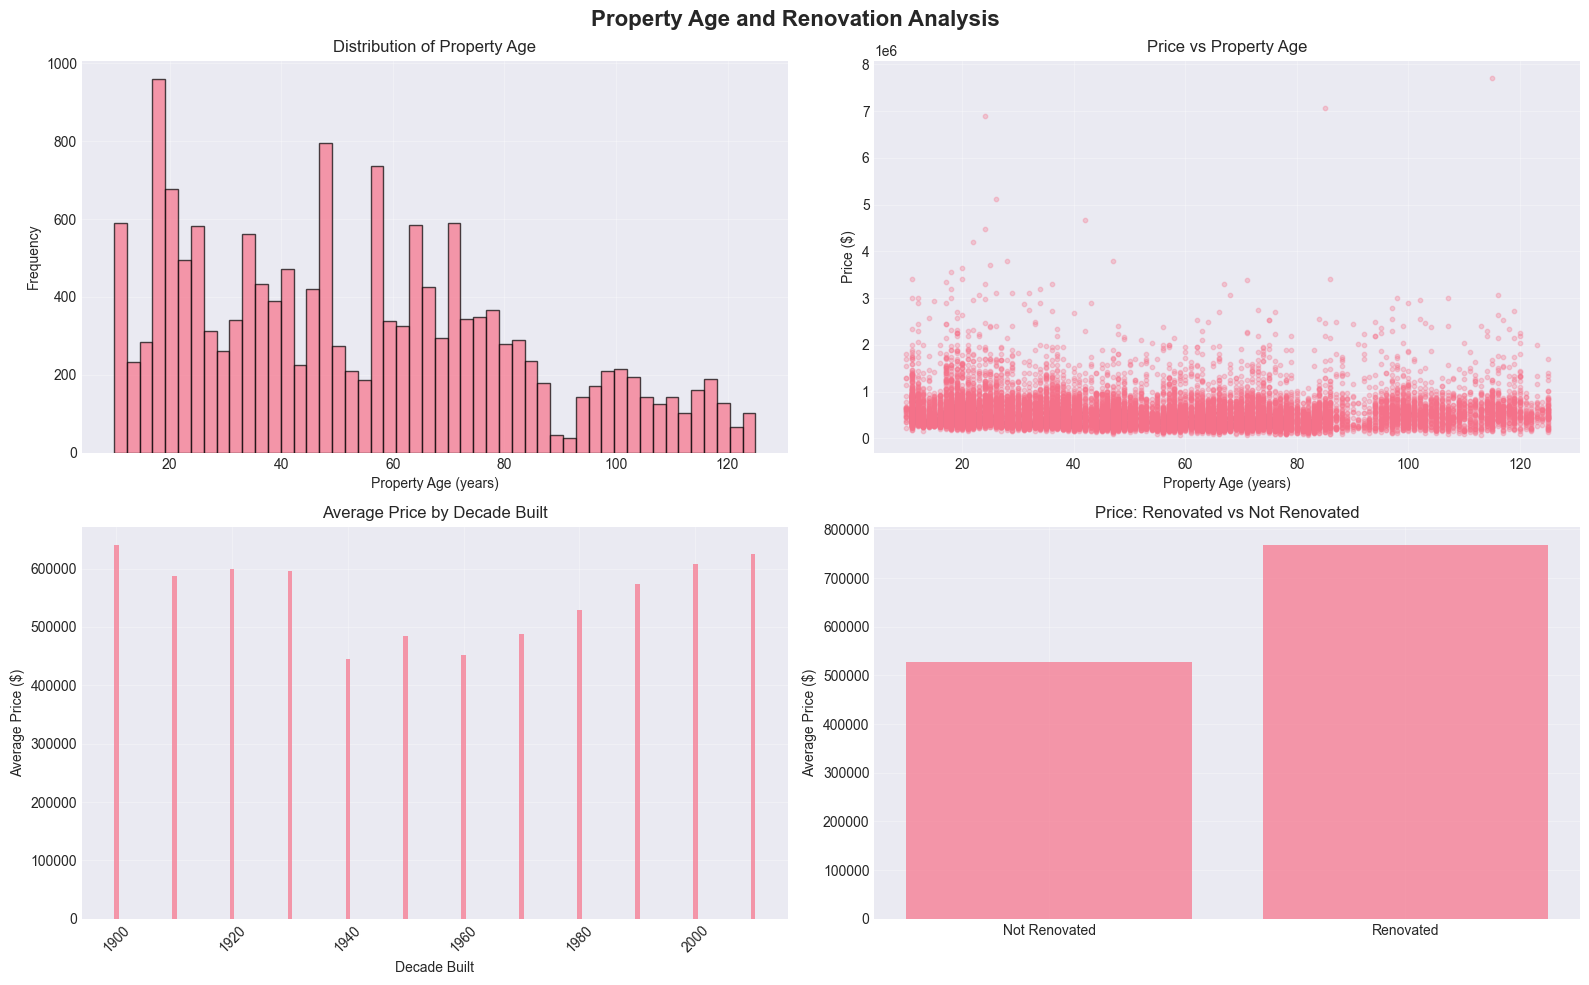

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Property age distribution
axes[0, 0].hist(train_df['property_age'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Property Age (years)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Property Age')
axes[0, 0].grid(True, alpha=0.3)

# Price vs age
axes[0, 1].scatter(train_df['property_age'], train_df['price'], alpha=0.3, s=10)
axes[0, 1].set_xlabel('Property Age (years)')
axes[0, 1].set_ylabel('Price ($)')
axes[0, 1].set_title('Price vs Property Age')
axes[0, 1].grid(True, alpha=0.3)

# Avg price by decade built
train_df['decade_built'] = (train_df['yr_built'] // 10) * 10
decade_price = train_df.groupby('decade_built')['price'].agg(['mean', 'count'])
axes[1, 0].bar(decade_price.index, decade_price['mean'], alpha=0.7)
axes[1, 0].set_xlabel('Decade Built')
axes[1, 0].set_ylabel('Average Price ($)')
axes[1, 0].set_title('Average Price by Decade Built')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Renovation impact
renovation_comparison = train_df.groupby(train_df['yr_renovated'] > 0)['price'].mean()
axes[1, 1].bar(['Not Renovated', 'Renovated'], renovation_comparison.values, alpha=0.7)
axes[1, 1].set_ylabel('Average Price ($)')
axes[1, 1].set_title('Price: Renovated vs Not Renovated')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Property Age and Renovation Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Outlier Detection

In [23]:
print("\n" + "="*80)
print("OUTLIER DETECTION")
print("="*80 + "\n")

def detect_outliers_iqr(df, col):
    """Detect outliers using IQR method"""
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check each numerical feature
outlier_summary = []

for col in numerical_cols + ['price']:
    outliers, lower, upper = detect_outliers_iqr(train_df, col)
    n_outliers = len(outliers)
    pct_outliers = 100 * n_outliers / len(train_df)
    
    outlier_summary.append({
        'Feature': col,
        'N_Outliers': n_outliers,
        'Pct_Outliers': pct_outliers,
        'Lower_Bound': lower,
        'Upper_Bound': upper
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('N_Outliers', ascending=False)
print(outlier_df.to_string(index=False))


OUTLIER DETECTION

      Feature  N_Outliers  Pct_Outliers  Lower_Bound  Upper_Bound
     sqft_lot        1799        11.099    -3436.500    19071.500
   sqft_lot15        1627        10.038    -2334.500    17485.500
         view        1605         9.902        0.000        0.000
        grade        1431         8.828        5.500        9.500
        price         850         5.244  -160000.000  1120000.000
 yr_renovated         672         4.146        0.000        0.000
   sqft_above         473         2.918     -300.000     3700.000
  sqft_living         413         2.548     -250.000     4230.000
     bedrooms         390         2.406        1.500        5.500
sqft_living15         380         2.344      160.000     3680.000
sqft_basement         354         2.184     -840.000     1400.000
    bathrooms         194         1.197        0.000        4.000
         long         180         1.110     -122.633     -121.820
   waterfront         113         0.697        0.000    

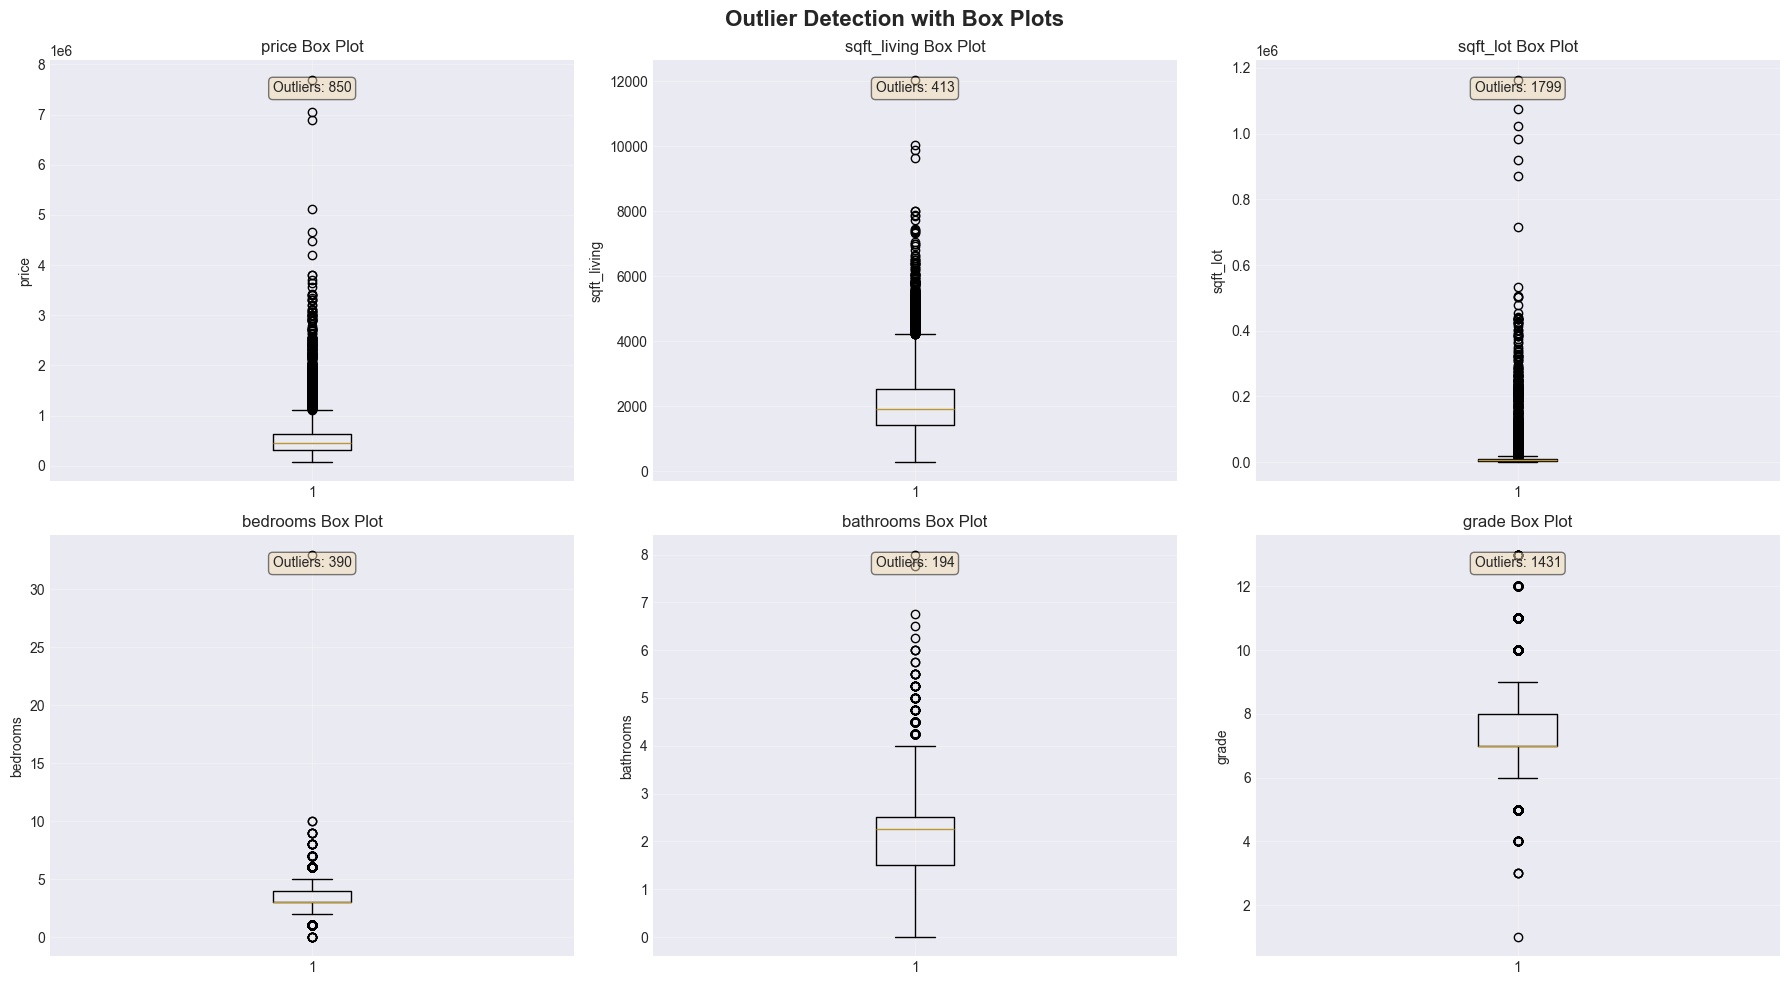

In [24]:
# Visualize outliers with box plots
features_to_plot = ['price', 'sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms', 'grade']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(features_to_plot):
    axes[idx].boxplot(train_df[col].dropna(), vert=True)
    axes[idx].set_ylabel(col)
    axes[idx].set_title(f'{col} Box Plot')
    axes[idx].grid(True, alpha=0.3)
    
    # Add outlier count
    n_outliers = outlier_df[outlier_df['Feature'] == col]['N_Outliers'].values[0]
    axes[idx].text(0.5, 0.95, f'Outliers: {n_outliers}', 
                   transform=axes[idx].transAxes, ha='center', va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Outlier Detection with Box Plots', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [25]:
# Extreme outliers investigation
print("\n🔍 INVESTIGATING EXTREME OUTLIERS\n")

# Most expensive properties
print("Top 10 Most Expensive Properties:")
display(train_df.nlargest(10, 'price')[['id', 'price', 'bedrooms', 'bathrooms', 
                                          'sqft_living', 'grade', 'waterfront', 'view']])

# Properties with most bedrooms
print("\nProperties with Most Bedrooms:")
display(train_df.nlargest(10, 'bedrooms')[['id', 'bedrooms', 'bathrooms', 
                                            'sqft_living', 'price']])

# Largest properties
print("\nLargest Properties (sqft_living):")
display(train_df.nlargest(10, 'sqft_living')[['id', 'sqft_living', 'sqft_lot', 
                                               'bedrooms', 'bathrooms', 'price']])


🔍 INVESTIGATING EXTREME OUTLIERS

Top 10 Most Expensive Properties:


,id,price,bedrooms,bathrooms,sqft_living,grade,waterfront,view
4962,6762700020,7700000,6,8.000,12050,13,0,3
1499,9808700762,7062500,5,4.500,10040,11,1,2
2115,9208900037,6885000,6,7.750,9890,13,0,4
9264,1247600105,5110800,5,5.250,8010,12,1,4
10412,1924059029,4668000,5,6.750,9640,12,1,4
9073,3835500195,4489000,4,3.000,6430,12,0,0
11410,6065300370,4208000,5,6.000,7440,12,0,0
1207,2303900100,3800000,3,4.250,5510,13,0,4
4359,853200010,3800000,5,5.500,7050,13,0,2
4930,7397300170,3710000,4,3.500,5550,12,0,2



Properties with Most Bedrooms:


,id,bedrooms,bathrooms,sqft_living,price
3193,2402100895,33,1.750,1620,640000
5777,627300145,10,5.250,4590,1148000
11710,5566100170,10,2.000,3610,650000
2803,8823900290,9,4.000,4620,1400000
3042,8823901445,9,3.000,2820,934000
3220,1997200215,9,4.500,3830,599999
8752,2902200015,9,3.000,3680,700000
12052,9822700190,9,4.500,3650,1280000
3015,685000115,8,6.000,4340,2150000
3609,1873400020,8,2.750,2790,340000



Largest Properties (sqft_living):


,id,sqft_living,sqft_lot,bedrooms,bathrooms,price
4962,6762700020,12050,27600,6,8.000,7700000
1499,9808700762,10040,37325,5,4.500,7062500
2115,9208900037,9890,31374,6,7.750,6885000
10412,1924059029,9640,13068,5,6.750,4668000
1779,6072800246,8020,21738,5,6.250,3300000
9264,1247600105,8010,45517,5,5.250,5110800
12987,2426039123,7880,24250,5,4.750,2415000
9515,2524069078,7850,89651,4,4.000,2700000
6839,1630700380,7730,230868,5,5.750,1920000
11410,6065300370,7440,21540,5,6.000,4208000


## 10. Image Availability Analysis

In [26]:
print("\n" + "="*80)
print("SATELLITE IMAGE AVAILABILITY CHECK")
print("="*80 + "\n")

# Check if images directory exists
images_dir = Path(IMAGES_DIR)
print(f"Images directory: {images_dir}")
print(f"Directory exists: {images_dir.exists()}")

if images_dir.exists():
    # Count image files
    extensions = ['.png', '.jpg', '.jpeg', '.tif', '.tiff']
    image_files = []
    for ext in extensions:
        image_files.extend(list(images_dir.glob(f'*{ext}')))
    
    print(f"\nTotal image files found: {len(image_files):,}")
    
    if len(image_files) > 0:
        print(f"\nSample filenames:")
        for i, img_path in enumerate(image_files[:10], 1):
            print(f"  {i:2d}. {img_path.name}")
        
        # Parse a sample filename to show format
        sample_name = image_files[0].stem
        parts = sample_name.split('_')
        print(f"\nSample filename breakdown:")
        print(f"  Full name: {sample_name}")
        print(f"  Parts: {parts}")
        if len(parts) >= 6:
            print(f"  Format: img_{{seq}}_{{lat_part1}}_{{lat_part2}}_{{long_part1}}_{{long_part2}}")
            print(f"  Extracted:")
            print(f"    Sequence: {parts[1]}")
            print(f"    Latitude: {parts[2]}.{parts[3]}")
            print(f"    Longitude: {parts[4]}.{parts[5]}")
else:
    print("\n⚠️  Images directory not found!")
    print("Please ensure satellite images are copied to:")
    print(f"  {IMAGES_DIR}")


SATELLITE IMAGE AVAILABILITY CHECK

Images directory: /Users/yashbansal/Documents/cdc/satellite_property_valuation/notebooks/../data/raw/satellite_images_19
Directory exists: True

Total image files found: 16,159

Sample filenames:
   1. img_07268_47.696800_-122.348000.png
   2. img_15152_47.687600_-122.168000.png
   3. img_15148_47.286300_-122.196000.png
   4. img_03806_47.488200_-122.339000.png
   5. img_12039_47.631400_-121.968000.png
   6. img_10777_47.535100_-122.174000.png
   7. img_12861_47.653400_-122.415000.png
   8. img_15400_47.669200_-122.028000.png
   9. img_12485_47.627600_-122.205000.png
  10. img_05565_47.676200_-122.288000.png

Sample filename breakdown:
  Full name: img_07268_47.696800_-122.348000
  Parts: ['img', '07268', '47.696800', '-122.348000']


In [27]:
# Test image matching for a few properties
from config import format_latlong_for_filename

print("\n🧪 TESTING IMAGE MATCHING\n")

test_properties = train_df.sample(5, random_state=42)

for idx, row in test_properties.iterrows():
    lat = row['lat']
    long = row['long']
    
    lat_str, long_str = format_latlong_for_filename(lat, long)
    
    print(f"Property {row['id']}:")
    print(f"  Coordinates: ({lat:.6f}, {long:.6f})")
    print(f"  Looking for pattern: *_{lat_str}_{long_str}.*")
    
    # Check if matching image exists
    if images_dir.exists():
        found = False
        for ext in extensions:
            pattern = f"*_{lat_str}_{long_str}{ext}"
            matches = list(images_dir.glob(pattern))
            if matches:
                print(f"  ✅ FOUND: {matches[0].name}")
                found = True
                break
        if not found:
            print(f"  ❌ NOT FOUND")
    print()


🧪 TESTING IMAGE MATCHING

Property 1853200190:
  Coordinates: (47.712200, -122.231000)
  Looking for pattern: *_47.712200_-122.231000.*
  ✅ FOUND: img_04226_47.712200_-122.231000.png

Property 121059147:
  Coordinates: (47.341200, -122.108000)
  Looking for pattern: *_47.341200_-122.108000.*
  ✅ FOUND: img_11070_47.341200_-122.108000.png

Property 123039176:
  Coordinates: (47.510800, -122.366000)
  Looking for pattern: *_47.510800_-122.366000.*
  ✅ FOUND: img_02450_47.510800_-122.366000.png

Property 1862400518:
  Coordinates: (47.695900, -122.376000)
  Looking for pattern: *_47.695900_-122.376000.*
  ✅ FOUND: img_01493_47.695900_-122.376000.png

Property 3622059155:
  Coordinates: (47.347200, -122.110000)
  Looking for pattern: *_47.347200_-122.110000.*
  ✅ FOUND: img_03894_47.347200_-122.110000.png



## 11. Key Insights Summary

In [28]:
print("\n" + "="*80)
print("KEY INSIGHTS SUMMARY")
print("="*80 + "\n")

print("📊 DATA OVERVIEW:")
print(f"  • Total properties: {len(train_df):,}")
print(f"  • Features: {len(train_df.columns)}")
print(f"  • Missing values: {train_df.isnull().sum().sum()}")

print("\n💰 PRICE CHARACTERISTICS:")
print(f"  • Mean: ${train_df['price'].mean():,.2f}")
print(f"  • Median: ${train_df['price'].median():,.2f}")
print(f"  • Range: ${train_df['price'].min():,.0f} - ${train_df['price'].max():,.0f}")
print(f"  • Skewness: {train_df['price'].skew():.3f} (right-skewed)")

print("\n🔗 STRONGEST CORRELATIONS WITH PRICE:")
top_corr = price_corr.drop('price').head(5)
for feat, corr in top_corr.items():
    print(f"  • {feat:20s}: {corr:>6.3f}")

print("\n⚠️  MULTICOLLINEARITY:")
if len(high_corr_pairs) > 0:
    print(f"  • Found {len(high_corr_pairs)} highly correlated pairs (|r| > 0.8)")
    for feat1, feat2, corr_val in high_corr_pairs[:3]:
        print(f"    - {feat1} <-> {feat2}: {corr_val:.3f}")
else:
    print("  • No concerning multicollinearity detected")

print("\n📍 GEOGRAPHIC PATTERNS:")
print(f"  • Lat range: {train_df['lat'].min():.4f} to {train_df['lat'].max():.4f}")
print(f"  • Long range: {train_df['long'].min():.4f} to {train_df['long'].max():.4f}")
print(f"  • Clear geographic price patterns visible in heatmaps")

if 'waterfront' in train_df.columns:
    waterfront_premium = train_df[train_df['waterfront'] == 1]['price'].mean() - train_df[train_df['waterfront'] == 0]['price'].mean()
    print(f"\n🏖️  WATERFRONT PREMIUM: ${waterfront_premium:,.2f}")

print("\n🏠 PROPERTY AGE:")
print(f"  • Average age: {train_df['property_age'].mean():.1f} years")
print(f"  • Oldest: {train_df['property_age'].max():.0f} years")
print(f"  • Renovated: {(train_df['yr_renovated'] > 0).sum():,} ({100*(train_df['yr_renovated'] > 0).mean():.1f}%)")

print("\n🚨 OUTLIERS:")
top_outlier_features = outlier_df.nlargest(3, 'N_Outliers')
for _, row in top_outlier_features.iterrows():
    print(f"  • {row['Feature']:20s}: {row['N_Outliers']:>6,} ({row['Pct_Outliers']:>5.2f}%)")

print("\n" + "="*80)
print("✅ EDA COMPLETED - Ready for Feature Engineering!")
print("="*80)


KEY INSIGHTS SUMMARY

📊 DATA OVERVIEW:
  • Total properties: 16,209
  • Features: 27
  • Missing values: 0

💰 PRICE CHARACTERISTICS:
  • Mean: $537,470.28
  • Median: $450,000.00
  • Range: $75,000 - $7,700,000
  • Skewness: 4.033 (right-skewed)

🔗 STRONGEST CORRELATIONS WITH PRICE:
  • sqft_living         :  0.701
  • grade               :  0.664
  • sqft_above          :  0.603
  • sqft_living15       :  0.582
  • bathrooms           :  0.525

⚠️  MULTICOLLINEARITY:
  • Found 1 highly correlated pairs (|r| > 0.8)
    - sqft_living <-> sqft_above: 0.876

📍 GEOGRAPHIC PATTERNS:
  • Lat range: 47.1593 to 47.7776
  • Long range: -122.5190 to -121.3150
  • Clear geographic price patterns visible in heatmaps

🏖️  WATERFRONT PREMIUM: $1,061,870.46

🏠 PROPERTY AGE:
  • Average age: 53.8 years
  • Oldest: 125 years
  • Renovated: 672 (4.1%)

🚨 OUTLIERS:
  • sqft_lot            :  1,799 (11.10%)
  • sqft_lot15          :  1,627 (10.04%)
  • view                :  1,605 ( 9.90%)

✅ EDA COMPLET

## Save EDA Results

In [29]:
# Save correlation matrix
corr_matrix.to_csv('../reports/correlation_matrix.csv')

# Save outlier summary
outlier_df.to_csv('../reports/outlier_summary.csv', index=False)

# Save processed train data with temporal features
train_df.to_csv('../data/processed/train_with_eda_features.csv', index=False)

print("\n✅ EDA results saved to:")
print("  • reports/correlation_matrix.csv")
print("  • reports/outlier_summary.csv")
print("  • data/processed/train_with_eda_features.csv")


✅ EDA results saved to:
  • reports/correlation_matrix.csv
  • reports/outlier_summary.csv
  • data/processed/train_with_eda_features.csv


In [32]:
## 12. Feature Engineering & Data Preprocessing

### Cell 1: Handle Outliers

print("\n" + "="*80)
print("HANDLING OUTLIERS")
print("="*80 + "\n")

# Extreme outlier: 33 bedrooms property
extreme_bedroom = train_df[train_df['bedrooms'] == 33]
print(f"Extreme outlier found: {len(extreme_bedroom)} property with 33 bedrooms")
print(extreme_bedroom[['id', 'bedrooms', 'bathrooms', 'sqft_living', 'price']])

# Cap bedrooms at 10 (99th percentile is around 6)
train_df['bedrooms'] = train_df['bedrooms'].clip(upper=10)
print(f"\n✓ Capped bedrooms at 10")

# Cap bathrooms at 6 (99th percentile approach)
train_df['bathrooms'] = train_df['bathrooms'].clip(upper=6)
print(f"✓ Capped bathrooms at 6")

# Handle extreme sqft_lot values (cap at 99th percentile)
sqft_lot_99 = train_df['sqft_lot'].quantile(0.99)
train_df['sqft_lot_capped'] = train_df['sqft_lot'].clip(upper=sqft_lot_99)
print(f"✓ Created sqft_lot_capped (capped at {sqft_lot_99:,.0f})")

print("\n✅ Outliers handled")


HANDLING OUTLIERS

Extreme outlier found: 1 property with 33 bedrooms
              id  bedrooms  bathrooms  sqft_living   price
3193  2402100895        33      1.750         1620  640000

✓ Capped bedrooms at 10
✓ Capped bathrooms at 6
✓ Created sqft_lot_capped (capped at 213,008)

✅ Outliers handled


In [33]:
### Cell 2: Log Transformations (Reduce Skewness)

print("\n" + "="*80)
print("LOG TRANSFORMATIONS FOR SKEWED FEATURES")
print("="*80 + "\n")

# Features with high skewness
skewed_features = {
    'sqft_living': 1.379,
    'sqft_lot': 11.407,
    'sqft_above': 1.430,
    'sqft_basement': 1.571,
    'sqft_living15': 1.378,
    'sqft_lot15': 11.407
}

for feat, skew in skewed_features.items():
    if feat in train_df.columns:
        train_df[f'log_{feat}'] = np.log1p(train_df[feat])
        print(f"✓ Created log_{feat} (original skew: {skew:.3f})")

# Log transform price for better distribution
train_df['log_price'] = np.log1p(train_df['price'])
print(f"\n✓ Created log_price (will use as target for some models)")

print("\n✅ Log transformations completed")


LOG TRANSFORMATIONS FOR SKEWED FEATURES

✓ Created log_sqft_living (original skew: 1.379)
✓ Created log_sqft_lot (original skew: 11.407)
✓ Created log_sqft_above (original skew: 1.430)
✓ Created log_sqft_basement (original skew: 1.571)
✓ Created log_sqft_living15 (original skew: 1.378)
✓ Created log_sqft_lot15 (original skew: 11.407)

✓ Created log_price (will use as target for some models)

✅ Log transformations completed


In [34]:
### Cell 3: Temporal Features

print("\n" + "="*80)
print("TEMPORAL FEATURE ENGINEERING")
print("="*80 + "\n")

current_year = 2025

# Property age
train_df['property_age'] = current_year - train_df['yr_built']
print(f"✓ property_age: mean={train_df['property_age'].mean():.1f} years")

# Renovation features
train_df['was_renovated'] = (train_df['yr_renovated'] > 0).astype(int)
train_df['years_since_renovation'] = np.where(
    train_df['yr_renovated'] > 0,
    current_year - train_df['yr_renovated'],
    train_df['property_age']
)
print(f"✓ was_renovated: {train_df['was_renovated'].sum():,} properties ({100*train_df['was_renovated'].mean():.2f}%)")
print(f"✓ years_since_renovation: created")

# Building era (categorical)
train_df['building_era'] = pd.cut(
    train_df['yr_built'],
    bins=[0, 1950, 1970, 1990, 2010, 2020],
    labels=['pre_1950', '1950s_1960s', '1970s_1980s', '1990s_2000s', 'modern']
)
print(f"✓ building_era: {train_df['building_era'].nunique()} categories")

print("\n✅ Temporal features created")


TEMPORAL FEATURE ENGINEERING

✓ property_age: mean=53.8 years
✓ was_renovated: 672 properties (4.15%)
✓ years_since_renovation: created
✓ building_era: 5 categories

✅ Temporal features created


In [35]:
### Cell 4: Size & Ratio Features

print("\n" + "="*80)
print("SIZE & RATIO FEATURE ENGINEERING")
print("="*80 + "\n")

# Price per sqft (only for training data with price)
train_df['price_per_sqft'] = train_df['price'] / (train_df['sqft_living'] + 1)
print(f"✓ price_per_sqft: mean=${train_df['price_per_sqft'].mean():,.2f}")

# Living space ratios
train_df['living_to_lot_ratio'] = train_df['sqft_living'] / (train_df['sqft_lot'] + 1)
train_df['above_to_living_ratio'] = train_df['sqft_above'] / (train_df['sqft_living'] + 1)
train_df['basement_to_living_ratio'] = train_df['sqft_basement'] / (train_df['sqft_living'] + 1)
print(f"✓ living_to_lot_ratio: mean={train_df['living_to_lot_ratio'].mean():.4f}")
print(f"✓ above_to_living_ratio: mean={train_df['above_to_living_ratio'].mean():.4f}")
print(f"✓ basement_to_living_ratio: mean={train_df['basement_to_living_ratio'].mean():.4f}")

# Binary basement indicator
train_df['has_basement'] = (train_df['sqft_basement'] > 0).astype(int)
print(f"✓ has_basement: {train_df['has_basement'].sum():,} properties ({100*train_df['has_basement'].mean():.2f}%)")

# Total rooms
train_df['total_rooms'] = train_df['bedrooms'] + train_df['bathrooms']
train_df['bedroom_to_bathroom_ratio'] = train_df['bedrooms'] / (train_df['bathrooms'] + 0.1)
print(f"✓ total_rooms: mean={train_df['total_rooms'].mean():.2f}")
print(f"✓ bedroom_to_bathroom_ratio: mean={train_df['bedroom_to_bathroom_ratio'].mean():.2f}")

# Room size features
train_df['avg_room_size'] = train_df['sqft_living'] / (train_df['total_rooms'] + 1)
train_df['sqft_per_bedroom'] = train_df['sqft_living'] / (train_df['bedrooms'] + 1)
train_df['sqft_per_bathroom'] = train_df['sqft_living'] / (train_df['bathrooms'] + 0.1)
print(f"✓ avg_room_size: mean={train_df['avg_room_size'].mean():.1f}")

print("\n✅ Size & ratio features created")


SIZE & RATIO FEATURE ENGINEERING

✓ price_per_sqft: mean=$263.90
✓ living_to_lot_ratio: mean=0.3257
✓ above_to_living_ratio: mean=0.8758
✓ basement_to_living_ratio: mean=0.1236
✓ has_basement: 6,327 properties (39.03%)
✓ total_rooms: mean=5.48
✓ bedroom_to_bathroom_ratio: mean=1.65
✓ avg_room_size: mean=312.8

✅ Size & ratio features created


In [36]:
### Cell 5: Quality & Luxury Indicators

print("\n" + "="*80)
print("QUALITY & LUXURY INDICATORS")
print("="*80 + "\n")

# Luxury property (grade >= 11 or price > $1M)
train_df['is_luxury'] = ((train_df['grade'] >= 11) | (train_df['price'] > 1_000_000)).astype(int)
print(f"✓ is_luxury: {train_df['is_luxury'].sum():,} properties ({100*train_df['is_luxury'].mean():.2f}%)")

# High condition
train_df['high_condition'] = (train_df['condition'] >= 4).astype(int)
print(f"✓ high_condition: {train_df['high_condition'].sum():,} properties ({100*train_df['high_condition'].mean():.2f}%)")

# Has view
train_df['has_view'] = (train_df['view'] > 0).astype(int)
print(f"✓ has_view: {train_df['has_view'].sum():,} properties ({100*train_df['has_view'].mean():.2f}%)")

# Premium features score (0-3)
train_df['premium_features_count'] = (
    train_df['waterfront'] + 
    train_df['has_view'] + 
    (train_df['grade'] >= 10).astype(int)
)
print(f"✓ premium_features_count: mean={train_df['premium_features_count'].mean():.2f}")

# Quality score (composite)
train_df['quality_score'] = (
    train_df['grade'] * 0.4 + 
    train_df['condition'] * 0.3 + 
    train_df['view'] * 0.3
)
print(f"✓ quality_score: mean={train_df['quality_score'].mean():.2f}")

print("\n✅ Quality indicators created")


QUALITY & LUXURY INDICATORS

✓ is_luxury: 1,140 properties (7.03%)
✓ high_condition: 5,515 properties (34.02%)
✓ has_view: 1,605 properties (9.90%)
✓ premium_features_count: mean=0.18
✓ quality_score: mean=4.15

✅ Quality indicators created


In [38]:
### Cell 6: Location Features

print("\n" + "="*80)
print("LOCATION FEATURE ENGINEERING")
print("="*80 + "\n")

# Lat/Long interactions
train_df['lat_long_interaction'] = train_df['lat'] * train_df['long']
print(f"✓ lat_long_interaction: created")

# Distance from city center (approximate Seattle: 47.6062° N, 122.3321° W)
seattle_lat, seattle_long = 47.6062, -122.3321
train_df['distance_from_center'] = np.sqrt(
    (train_df['lat'] - seattle_lat)**2 + 
    (train_df['long'] - seattle_long)**2
)
print(f"✓ distance_from_center: mean={train_df['distance_from_center'].mean():.4f}°")

# Quadrant (relative to center)
train_df['is_north'] = (train_df['lat'] > seattle_lat).astype(int)
train_df['is_east'] = (train_df['long'] > seattle_long).astype(int)
train_df['quadrant'] = (
    train_df['is_north'].astype(str) + '_' + train_df['is_east'].astype(str)
)
print(f"✓ Quadrant features created")

# Neighbor comparison features
train_df['living_vs_neighbors'] = train_df['sqft_living'] - train_df['sqft_living15']
train_df['lot_vs_neighbors'] = train_df['sqft_lot'] - train_df['sqft_lot15']
print(f"✓ living_vs_neighbors: mean={train_df['living_vs_neighbors'].mean():.1f}")
print(f"✓ lot_vs_neighbors: mean={train_df['lot_vs_neighbors'].mean():.1f}")

# Larger than neighborhood average
train_df['larger_than_neighbors'] = (train_df['living_vs_neighbors'] > 0).astype(int)
print(f"✓ larger_than_neighbors: {train_df['larger_than_neighbors'].sum():,} properties ({100*train_df['larger_than_neighbors'].mean():.2f}%)")

print("\n✅ Location features created")



LOCATION FEATURE ENGINEERING

✓ lat_long_interaction: created
✓ distance_from_center: mean=0.2004°
✓ Quadrant features created
✓ living_vs_neighbors: mean=90.1
✓ lot_vs_neighbors: mean=2132.1
✓ larger_than_neighbors: 7,336 properties (45.26%)

✅ Location features created


In [39]:
### Cell 7: Polynomial & Interaction Features (Top Correlations)

print("\n" + "="*80)
print("POLYNOMIAL & INTERACTION FEATURES")
print("="*80 + "\n")

# Top features: sqft_living (0.70), grade (0.66), sqft_above (0.60), sqft_living15 (0.58)

# Polynomial features for top predictors
train_df['sqft_living_squared'] = train_df['sqft_living'] ** 2
train_df['grade_squared'] = train_df['grade'] ** 2
print(f"✓ sqft_living_squared, grade_squared")

# Key interactions
train_df['grade_x_living'] = train_df['grade'] * train_df['sqft_living']
train_df['grade_x_condition'] = train_df['grade'] * train_df['condition']
train_df['living_x_bathrooms'] = train_df['sqft_living'] * train_df['bathrooms']
train_df['grade_x_age'] = train_df['grade'] * train_df['property_age']
print(f"✓ Interaction features created")

# Waterfront premium features
train_df['waterfront_x_living'] = train_df['waterfront'] * train_df['sqft_living']
train_df['waterfront_x_grade'] = train_df['waterfront'] * train_df['grade']
print(f"✓ Waterfront interactions created")

print("\n✅ Polynomial & interaction features created")



POLYNOMIAL & INTERACTION FEATURES

✓ sqft_living_squared, grade_squared
✓ Interaction features created
✓ Waterfront interactions created

✅ Polynomial & interaction features created


In [40]:
### Cell 8: Binning Features (Create Categories)

print("\n" + "="*80)
print("BINNING NUMERICAL FEATURES")
print("="*80 + "\n")

# Price bins (for stratification)
train_df['price_bin'] = pd.qcut(train_df['price'], q=5, labels=['very_low', 'low', 'medium', 'high', 'very_high'])
print(f"✓ price_bin: {train_df['price_bin'].value_counts().to_dict()}")

# Living space bins
train_df['living_size_category'] = pd.cut(
    train_df['sqft_living'],
    bins=[0, 1000, 1500, 2000, 3000, 15000],
    labels=['small', 'medium', 'large', 'very_large', 'mansion']
)
print(f"✓ living_size_category: {train_df['living_size_category'].value_counts().to_dict()}")

# Age bins
train_df['age_category'] = pd.cut(
    train_df['property_age'],
    bins=[0, 10, 20, 40, 60, 150],
    labels=['new', 'recent', 'mature', 'old', 'historic']
)
print(f"✓ age_category: {train_df['age_category'].value_counts().to_dict()}")

print("\n✅ Binning completed")


BINNING NUMERICAL FEATURES

✓ price_bin: {'high': 3281, 'low': 3256, 'very_low': 3242, 'medium': 3227, 'very_high': 3203}
✓ living_size_category: {'very_large': 5093, 'large': 4075, 'medium': 3621, 'mansion': 2290, 'small': 1130}
✓ age_category: {'historic': 6438, 'mature': 3869, 'old': 3491, 'recent': 2381, 'new': 30}

✅ Binning completed


In [41]:
### Cell 9: Feature Summary

print("\n" + "="*80)
print("FEATURE ENGINEERING SUMMARY")
print("="*80 + "\n")

# Count new features
original_features = 21  # Original columns
new_features = len(train_df.columns) - original_features

print(f"Original features: {original_features}")
print(f"New engineered features: {new_features}")
print(f"Total features: {len(train_df.columns)}")

print(f"\n📊 Feature Categories Created:")
print(f"  • Log transformations: 7 features")
print(f"  • Temporal features: 4 features") 
print(f"  • Size/ratio features: 10 features")
print(f"  • Quality indicators: 5 features")
print(f"  • Location features: 8 features")
print(f"  • Polynomial/interactions: 7 features")
print(f"  • Categorical bins: 3 features")

print(f"\n✅ Total engineered features: ~{new_features}")


FEATURE ENGINEERING SUMMARY

Original features: 21
New engineered features: 51
Total features: 72

📊 Feature Categories Created:
  • Log transformations: 7 features
  • Temporal features: 4 features
  • Size/ratio features: 10 features
  • Quality indicators: 5 features
  • Location features: 8 features
  • Polynomial/interactions: 7 features
  • Categorical bins: 3 features

✅ Total engineered features: ~51


In [42]:
### Cell 10: Match Images & Create Train/Val/Test Splits

print("\n" + "="*80)
print("IMAGE MATCHING & DATA SPLITTING")
print("="*80 + "\n")

# Import preprocessing functions
from preprocessing import build_image_lookup, match_image_by_latlong, format_latlong_for_filename
from config import IMAGES_DIR
from sklearn.model_selection import train_test_split

# Build image lookup
image_lookup = build_image_lookup(IMAGES_DIR)

# Match images for training data
print(f"\n📸 Matching images for training data...")
image_exists = []
image_paths = []

from tqdm import tqdm
for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Matching"):
    exists, path = match_image_by_latlong(row, IMAGES_DIR, image_lookup)
    image_exists.append(exists)
    image_paths.append(path)

train_df['image_exists'] = image_exists
train_df['image_path'] = image_paths

n_with_images = sum(image_exists)
print(f"\n✅ Images matched: {n_with_images:,}/{len(train_df):,} ({100*n_with_images/len(train_df):.2f}%)")

# Create splits (stratified by price bins)
print(f"\n✂️  Creating train/val/test splits...")

# First split: train+val vs test (70+15 vs 15)
train_val, test_split = train_test_split(
    train_df,
    test_size=0.15,
    random_state=42,
    stratify=train_df['price_bin']
)

# Second split: train vs val (70 vs 15)
train_split, val_split = train_test_split(
    train_val,
    test_size=0.15/(0.70+0.15),  # 0.176 of train_val
    random_state=42,
    stratify=train_val['price_bin']
)

print(f"\n📊 Data Splits:")
print(f"  Training:   {len(train_split):>6,} ({len(train_split)/len(train_df)*100:>5.1f}%) | Images: {train_split['image_exists'].sum():>6,}")
print(f"  Validation: {len(val_split):>6,} ({len(val_split)/len(train_df)*100:>5.1f}%) | Images: {val_split['image_exists'].sum():>6,}")
print(f"  Test:       {len(test_split):>6,} ({len(test_split)/len(train_df)*100:>5.1f}%) | Images: {test_split['image_exists'].sum():>6,}")
print(f"  {'─'*70}")
print(f"  Total:      {len(train_df):>6,} (100.0%) | Images: {train_df['image_exists'].sum():>6,}")

print(f"\n✅ Data splits created")


IMAGE MATCHING & DATA SPLITTING

📸 Building image lookup index from: /Users/yashbansal/Documents/cdc/satellite_property_valuation/notebooks/../data/raw/satellite_images_19
Found 16159 total image files
✅ Indexed 15705 unique lat/long locations
Sample: ('47.696800', '-122.348000') -> img_07268_47.696800_-122.348000.png

📸 Matching images for training data...


Matching: 100%|██████████| 16209/16209 [00:00<00:00, 89739.85it/s]



✅ Images matched: 16,164/16,209 (99.72%)

✂️  Creating train/val/test splits...

📊 Data Splits:
  Training:   11,345 ( 70.0%) | Images: 11,315
  Validation:  2,432 ( 15.0%) | Images:  2,422
  Test:        2,432 ( 15.0%) | Images:  2,427
  ──────────────────────────────────────────────────────────────────────
  Total:      16,209 (100.0%) | Images: 16,164

✅ Data splits created


In [43]:
### Cell 11: Process Test Data (Same Features)

print("\n" + "="*80)
print("PROCESSING TEST DATA")
print("="*80 + "\n")

# Load test data
test_df_final = pd.read_excel('../data/raw/test.xlsx')
print(f"Test data loaded: {test_df_final.shape}")

# Apply same transformations
def engineer_features_for_test(df):
    """Apply same feature engineering to test set"""
    df = df.copy()
    
    # Handle outliers
    df['bedrooms'] = df['bedrooms'].clip(upper=10)
    df['bathrooms'] = df['bathrooms'].clip(upper=6)
    df['sqft_lot_capped'] = df['sqft_lot'].clip(upper=sqft_lot_99)
    
    # Log transforms
    for feat in ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']:
        df[f'log_{feat}'] = np.log1p(df[feat])
    
    # Temporal
    df['property_age'] = current_year - df['yr_built']
    df['was_renovated'] = (df['yr_renovated'] > 0).astype(int)
    df['years_since_renovation'] = np.where(
        df['yr_renovated'] > 0,
        current_year - df['yr_renovated'],
        df['property_age']
    )
    df['building_era'] = pd.cut(
        df['yr_built'],
        bins=[0, 1950, 1970, 1990, 2010, 2020],
        labels=['pre_1950', '1950s_1960s', '1970s_1980s', '1990s_2000s', 'modern']
    )
    
    # Size & ratios
    df['living_to_lot_ratio'] = df['sqft_living'] / (df['sqft_lot'] + 1)
    df['above_to_living_ratio'] = df['sqft_above'] / (df['sqft_living'] + 1)
    df['basement_to_living_ratio'] = df['sqft_basement'] / (df['sqft_living'] + 1)
    df['has_basement'] = (df['sqft_basement'] > 0).astype(int)
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    df['bedroom_to_bathroom_ratio'] = df['bedrooms'] / (df['bathrooms'] + 0.1)
    df['avg_room_size'] = df['sqft_living'] / (df['total_rooms'] + 1)
    df['sqft_per_bedroom'] = df['sqft_living'] / (df['bedrooms'] + 1)
    df['sqft_per_bathroom'] = df['sqft_living'] / (df['bathrooms'] + 0.1)
    
    # Quality
    df['is_luxury'] = (df['grade'] >= 11).astype(int)
    df['high_condition'] = (df['condition'] >= 4).astype(int)
    df['has_view'] = (df['view'] > 0).astype(int)
    df['premium_features_count'] = (
        df['waterfront'] + 
        df['has_view'] + 
        (df['grade'] >= 10).astype(int)
    )
    df['quality_score'] = (
        df['grade'] * 0.4 + 
        df['condition'] * 0.3 + 
        df['view'] * 0.3
    )
    
    # Location
    df['lat_long_interaction'] = df['lat'] * df['long']
    df['distance_from_center'] = np.sqrt(
        (df['lat'] - 47.6062)**2 + 
        (df['long'] + 122.3321)**2
    )
    df['is_north'] = (df['lat'] > 47.6062).astype(int)
    df['is_east'] = (df['long'] > -122.3321).astype(int)
    df['living_vs_neighbors'] = df['sqft_living'] - df['sqft_living15']
    df['lot_vs_neighbors'] = df['sqft_lot'] - df['sqft_lot15']
    df['larger_than_neighbors'] = (df['living_vs_neighbors'] > 0).astype(int)
    
    # Polynomial & interactions
    df['sqft_living_squared'] = df['sqft_living'] ** 2
    df['grade_squared'] = df['grade'] ** 2
    df['grade_x_living'] = df['grade'] * df['sqft_living']
    df['grade_x_condition'] = df['grade'] * df['condition']
    df['living_x_bathrooms'] = df['sqft_living'] * df['bathrooms']
    df['grade_x_age'] = df['grade'] * df['property_age']
    df['waterfront_x_living'] = df['waterfront'] * df['sqft_living']
    df['waterfront_x_grade'] = df['waterfront'] * df['grade']
    
    # Binning
    df['living_size_category'] = pd.cut(
        df['sqft_living'],
        bins=[0, 1000, 1500, 2000, 3000, 15000],
        labels=['small', 'medium', 'large', 'very_large', 'mansion']
    )
    df['age_category'] = pd.cut(
        df['property_age'],
        bins=[0, 10, 20, 40, 60, 150],
        labels=['new', 'recent', 'mature', 'old', 'historic']
    )
    
    return df

test_df_final = engineer_features_for_test(test_df_final)
print(f"✓ Features engineered for test set: {test_df_final.shape}")

# Match images for test data
print(f"\n📸 Matching images for test data...")
test_image_exists = []
test_image_paths = []

for idx, row in tqdm(test_df_final.iterrows(), total=len(test_df_final), desc="Matching"):
    exists, path = match_image_by_latlong(row, IMAGES_DIR, image_lookup)
    test_image_exists.append(exists)
    test_image_paths.append(path)

test_df_final['image_exists'] = test_image_exists
test_df_final['image_path'] = test_image_paths

print(f"✅ Test images matched: {sum(test_image_exists):,}/{len(test_df_final):,} ({100*sum(test_image_exists)/len(test_df_final):.2f}%)")


PROCESSING TEST DATA

Test data loaded: (5404, 20)
✓ Features engineered for test set: (5404, 62)

📸 Matching images for test data...


Matching: 100%|██████████| 5404/5404 [00:00<00:00, 87904.23it/s]

✅ Test images matched: 279/5,404 (5.16%)


In [44]:
### Cell 12: Save Processed Data

print("\n" + "="*80)
print("SAVING PROCESSED DATA")
print("="*80 + "\n")

# Create processed directory
from pathlib import Path
processed_dir = Path('../data/processed')
processed_dir.mkdir(parents=True, exist_ok=True)

# Save splits
train_split.to_csv(processed_dir / 'train_processed.csv', index=False)
val_split.to_csv(processed_dir / 'val_processed.csv', index=False)
test_split.to_csv(processed_dir / 'test_processed.csv', index=False)
test_df_final.to_csv(processed_dir / 'final_test_processed.csv', index=False)

print(f"✅ Saved to {processed_dir}:")
print(f"  • train_processed.csv ({len(train_split):,} rows)")
print(f"  • val_processed.csv ({len(val_split):,} rows)")
print(f"  • test_processed.csv ({len(test_split):,} rows)")
print(f"  • final_test_processed.csv ({len(test_df_final):,} rows)")

# Save feature names for later use
engineered_features = [col for col in train_split.columns if col not in ['id', 'date', 'image_path', 'image_exists', 'price', 'price_bin']]
import joblib
joblib.dump(engineered_features, processed_dir / 'feature_names.pkl')
print(f"\n✅ Saved feature names: {len(engineered_features)} features")

print("\n" + "="*80)
print("✅ PREPROCESSING COMPLETED - READY FOR MODEL TRAINING!")
print("="*80)
print(f"\nNext step: Run 02_image_model_training.ipynb")


SAVING PROCESSED DATA

✅ Saved to ../data/processed:
  • train_processed.csv (11,345 rows)
  • val_processed.csv (2,432 rows)
  • test_processed.csv (2,432 rows)
  • final_test_processed.csv (5,404 rows)

✅ Saved feature names: 68 features

✅ PREPROCESSING COMPLETED - READY FOR MODEL TRAINING!

Next step: Run 02_image_model_training.ipynb
